In [2]:
# Imports
import os, math, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

## Models
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from catboost import CatBoostClassifier

## Evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [3]:
### GLOBAL VARIABLES ###
RAND_STATE = 0
N_FOLDS = 5

### FUNCTIONS ###
def saveResult(y_pred, name):
    '''Saves predicted labels to csv file'''
    
    results_dict = {
        "id": np.arange(1, y_pred.size + 1),
        "prediction": y_pred
    }
    results = pd.DataFrame(results_dict)
    path = "dump/submissions/" + name
    print("Saved submission file to:", path)
    results.to_csv(path, index=False)
    
def runL0Model(model, X_alltrain, y_alltrain, X_test=None,
               cv_filename=None, proba_filename=None,
               n_folds=N_FOLDS, random_state=RAND_STATE,
               **kwargs):
    '''Runs Level 0 model in a stacked ensemble using k-fold predictions
    1) Logs CV results for Level 0 model
    2) Saves k-fold CV probabillities for Level 1 models
    3) Saves test set probabilities
    '''
    
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True,
                          random_state=random_state)
    
    list_ypred_train = []
    list_y_train = []
    list_ypred_vld = []
    list_y_vld = []
    p_alltrain = np.zeros(X_alltrain.shape[0]) # Initialise probabilties
    for i, (train_idx, vld_idx) in enumerate(skf.split(X_alltrain, y_alltrain)):
        X_train = X_alltrain.iloc[train_idx,:]
        y_train = y_alltrain.iloc[train_idx]
        X_vld = X_alltrain.iloc[vld_idx,:]
        y_vld = y_alltrain.iloc[vld_idx]
        
        model.fit(X_train, y_train, **kwargs)
        
        p_train = model.predict_proba(X_train)[:,1]
        ypred_train = (p_train > 0.5).astype(int)
        
        p_vld = model.predict_proba(X_vld)[:,1]
        # Save proba from validation fold
        p_alltrain[vld_idx] = p_vld
        ypred_vld = (p_vld > 0.5).astype(int)
        
        # Appending to list
        list_y_train.append(y_train)
        list_ypred_train.append(ypred_train)
        list_y_vld.append(y_vld)
        list_ypred_vld.append(ypred_vld)
        
        print("Fold {} is completed!".format(i))
        
#         print("Train set:")
#         print(confusion_matrix(y_train, ypred_train))
#         print("Accuracy = {:.5f}, F1 = {:.5f}".format(
#             accuracy_score(y_train, ypred_train),
#             f1_score(y_train, ypred_train)))

#         print("Validation set:")
#         print(confusion_matrix(y_vld, ypred_vld))
#         print("Accuracy = {:.5f}, F1 = {:.5f}\n".format(
#             accuracy_score(y_vld, ypred_vld),
#             f1_score(y_vld, ypred_vld)))
        
    print("Consolidated validation folds:")
    ypred_alltrain = (p_alltrain > 0.5).astype(int)
    print("Accuracy = {:.5f}, F1 = {:.5f}".format(
        accuracy_score(y_alltrain, ypred_alltrain),
        f1_score(y_alltrain, ypred_alltrain)))
    print("\np_alltrain:", p_alltrain.shape)
    
    if X_test is not None:
        # Prediction of test set with model fitted on entire training set
        model.fit(X_alltrain, y_alltrain, **kwargs)
        p_test = model.predict_proba(X_test)[:,1]
        print("p_test:", p_test.shape)
        pkl_obj = [p_alltrain, p_test] # Container object to be returned
    else:
        pkl_obj = p_alltrain
    
    if proba_filename is not None:
        # Pickles prediction probabilities
        proba_path = os.path.join("dump/proba/", proba_filename)
        print("Saving prediction probabilities to:", proba_path)
        with open(proba_path, "wb") as f:
            pkl.dump(pkl_obj, f)
    
    if cv_filename is not None:
        # Pickles cross validation predictions
        cv_path = os.path.join("dump/log/", cv_filename)
        print("Saving CV predictions to:", cv_path)
        with open(cv_path, "wb") as f:
            pkl.dump([list_y_train, list_ypred_train,
                      list_y_vld, list_ypred_vld], f)
    
    return pkl_obj

def printCVResults(filename):
    cv_path = os.path.join("dump/log/", filename)
    with open(cv_path, "rb") as f:
        list_list = pkl.load(f)
        # [list_y_train, list_ypred_train
        # list_y_vld, list_ypred_vld]

    train_acc = []
    vld_acc = []
    train_f1 = []
    vld_f1 = []
    for y_train, ypred_train, y_vld, ypred_vld in zip(*list_list):
        print("Train set:")
        print(confusion_matrix(y_train, ypred_train))
        print("Accuracy = {:.5f}, F1 = {:.5f}".format(
            accuracy_score(y_train, ypred_train),
            f1_score(y_train, ypred_train)))

        print("Validation set:")
        print(confusion_matrix(y_vld, ypred_vld))
        print("Accuracy = {:.5f}, F1 = {:.5f}\n".format(
            accuracy_score(y_vld, ypred_vld),
            f1_score(y_vld, ypred_vld)))    

        train_acc.append(accuracy_score(y_train, ypred_train))
        vld_acc.append(accuracy_score(y_vld, ypred_vld))
        train_f1.append(f1_score(y_train, ypred_train))
        vld_f1.append(f1_score(y_vld, ypred_vld))

    mean_train_acc = np.mean(train_acc)
    std_train_acc = np.std(train_acc)
    mean_vld_acc = np.mean(vld_acc)
    std_vld_acc = np.std(vld_acc)
    
    mean_train_f1 = np.mean(train_f1)
    std_train_f1 = np.std(train_f1)
    mean_vld_f1 = np.mean(vld_f1)
    std_vld_f1 = np.std(vld_f1)
    
    print(cv_path)
    print("Training accuracy: {:.2f} +/- {:.2f}%".format(
        mean_train_acc*100, std_train_acc*100))
    print("Validation accuracy: {:.2f} +/- {:.2f}%".format(
        mean_vld_acc*100, std_vld_acc*100))
    print("Training F1: {:.4f} +/- {:.4f}%".format(
        mean_train_f1, std_train_f1))
    print("Validation F1: {:.4f} +/- {:.4f}%\n".format(
        mean_vld_f1, std_vld_f1))

def calcNCombinations(params_grid):
    '''Calculates number of all possible combinations'''
    list_lengths = [len(x) for x in params_grid.values()]
    return np.prod(list_lengths)
  
def runRandSearchCV(model, params_grid, params_search,
                    X_alltrain, y_alltrain, filename, params_fit={}):
    '''Run randomized cross-validation search and pickle best parameters'''
    
    print("Number of all possible combinations:",
          calcNCombinations(params_grid))

    # Random search of parameters across n_iter different
    # combinations using all available cores
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_grid,
        n_jobs=-1,
        **params_search
    )
    
    start_time = time.time()
    grid_search.fit(X_alltrain, y_alltrain, **params_fit) # Grid search fit!
    elapsed_time = time.time() - start_time
    print("Model fit duration:",
          time.strftime("%H h %M min %S s", time.gmtime(elapsed_time)))
    
    params_wpath = os.path.join("dump/params/", filename)
    print("Saved grid search results to: {}\n".format(params_wpath))
    with open(params_wpath, "wb") as f:
        pkl.dump(grid_search.cv_results_, f)
        
    return grid_search.cv_results_

def getGridSearchParams(filename):
    params_path = os.path.join("dump/params/", filename)
    with open(params_path, "rb") as f:
        results_dict = pkl.load(f)
    results = pd.DataFrame(results_dict)
    
    # Best params (Accuracy)
    idx_acc = results.mean_test_accuracy.idxmax()
    print("Best params (Accuracy): {}".format(results.params[idx_acc]))
    print("Training accuracy: {:.3f} +/- {:.3f}%".format(
        results.mean_train_accuracy[idx_acc]*100,
        results.std_train_accuracy[idx_acc]*100))
    print("Validation accuracy: {:.3f} +/- {:.3f}%\n".format(
        results.mean_test_accuracy[idx_acc]*100,
        results.std_test_accuracy[idx_acc]*100))

    # Best params (F1)
    idx_f1 = results.mean_test_f1.idxmax()
    print("Best params (F1): {}".format(results.params[idx_f1]))
    print("Training F1: {:.3f} +/- {:.3f}%".format(
        results.mean_train_f1[idx_f1]*100,
        results.std_train_f1[idx_f1]*100))
    print("Validation F1: {:.3f} +/- {:.3f}%".format(
        results.mean_test_f1[idx_f1]*100,
        results.std_test_f1[idx_f1]*100))
    print("Training accuracy: {:.3f} +/- {:.3f}%".format(
        results.mean_train_accuracy[idx_f1]*100,
        results.std_train_accuracy[idx_f1]*100))
    print("Validation accuracy: {:.3f} +/- {:.3f}%\n".format(
        results.mean_test_accuracy[idx_f1]*100,
        results.std_test_accuracy[idx_f1]*100))
    
    return (results.params[idx_acc], results.params[idx_f1], results)

### Model: Random Forest

In [4]:
# IMPORT DATA 1
DATA_RPATH = "dump/data/nopp.pkl"
with open(DATA_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)

In [21]:
## MODEL 1: Not weighted for class imbalance
params_model = {
    'n_estimators': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 5,
    'bootstrap': True
#     'class_weight': 'balanced_subsample'
}

rf = RandomForestClassifier(**params_model, random_state=0)

p_alltrain1 = runL0Model(rf, nopp_alltrain, y_alltrain)

Fold 0 is completed!
Fold 1 is completed!
Fold 2 is completed!
Fold 3 is completed!
Fold 4 is completed!
Consolidated validation folds:
Accuracy = 0.83113, F1 = 0.50928

p_alltrain: (24421,)


In [31]:
## MODEL 2
params_rf = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True,
    'class_weight':'balanced_subsample' # class imbalance
}
rf = RandomForestClassifier(**params_rf, random_state=0)

runL0Model(rf, nopp_alltrain, y_alltrain, "stack1/nopp_rf2.pkl", nopp_test)

Fold 0
Train set:
[[12773  2075]
 [  410  4278]]
Accuracy = 0.87280, F1 = 0.77493
Validation set:
[[3162  550]
 [ 211  962]]
Accuracy = 0.84422, F1 = 0.71657

Fold 1
Train set:
[[12750  2098]
 [  417  4272]]
Accuracy = 0.87127, F1 = 0.77258
Validation set:
[[3097  615]
 [ 201  971]]
Accuracy = 0.83292, F1 = 0.70413

Fold 2
Train set:
[[12763  2085]
 [  421  4268]]
Accuracy = 0.87173, F1 = 0.77305
Validation set:
[[3087  625]
 [ 196  976]]
Accuracy = 0.83190, F1 = 0.70393

Fold 3
Train set:
[[12820  2028]
 [  422  4267]]
Accuracy = 0.87460, F1 = 0.77695
Validation set:
[[3098  614]
 [ 210  962]]
Accuracy = 0.83129, F1 = 0.70015

Fold 4
Train set:
[[12800  2048]
 [  426  4263]]
Accuracy = 0.87337, F1 = 0.77509
Validation set:
[[3076  636]
 [ 176  996]]
Accuracy = 0.83374, F1 = 0.71041

Consolidated validation folds:
Accuracy = 0.83481, F1 = 0.70700
p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack1/nopp_rf2.pkl


#### Evaluation of datasets

In [86]:
# IMPORT DATA
DATA_RPATH = "dump/data/nopp.pkl"
with open(DATA_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)

print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

best_params = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True,
    'random_state': RAND_STATE
}
rf = RandomForestClassifier(**best_params)

p_alltrain = runL0Model(rf, nopp_alltrain, y_alltrain,
                        cv_filename='nopp_rf_hanae.pkl')

printCVResults("nopp_rf_hanae.pkl")

(24421, 103)
(24421,)
(24421, 103)
Fold 0 is completed!
Fold 1 is completed!
Fold 2 is completed!
Fold 3 is completed!
Fold 4 is completed!
Consolidated validation folds:
Accuracy = 0.86262, F1 = 0.68202

p_alltrain: (24421,)
Saving CV predictions to: dump/log/stack2/nopp_rf_hanae.pkl
Train set:
[[14265   583]
 [ 1462  3226]]
Accuracy = 0.89532, F1 = 0.75933
Validation set:
[[3524  188]
 [ 459  714]]
Accuracy = 0.86755, F1 = 0.68819

Train set:
[[14281   567]
 [ 1484  3205]]
Accuracy = 0.89502, F1 = 0.75759
Validation set:
[[3487  225]
 [ 466  706]]
Accuracy = 0.85852, F1 = 0.67142

Train set:
[[14262   586]
 [ 1439  3250]]
Accuracy = 0.89635, F1 = 0.76246
Validation set:
[[3495  217]
 [ 465  707]]
Accuracy = 0.86036, F1 = 0.67462

Train set:
[[14252   596]
 [ 1426  3263]]
Accuracy = 0.89650, F1 = 0.76345
Validation set:
[[3498  214]
 [ 458  714]]
Accuracy = 0.86241, F1 = 0.68000

Train set:
[[14261   587]
 [ 1430  3259]]
Accuracy = 0.89676, F1 = 0.76368
Validation set:
[[3464  248]
 [

In [21]:
# IMPORT DATA
DATA_RPATH = "dump/data/raw2a.pkl"
with open(DATA_RPATH, "rb") as f:
    raw2a_alltrain, y_alltrain, raw2a_test = pkl.load(f)

print(raw2a_alltrain.shape)
print(y_alltrain.shape)
print(raw2a_test.shape)

best_params = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True,
    'random_state': RAND_STATE
}
rf = RandomForestClassifier(**best_params)

p_alltrain = runL0Model(rf, raw2a_alltrain, y_alltrain,
                        cv_filename="raw2a-rf_hanae.pkl")

(24421, 86)
(24421,)
(24421, 86)
Fold 0
Train set:
[[14260   588]
 [ 1502  3186]]
Accuracy = 0.89302, F1 = 0.75301
Validation set:
[[3529  183]
 [ 458  715]]
Accuracy = 0.86878, F1 = 0.69049

Fold 1
Train set:
[[14273   575]
 [ 1488  3201]]
Accuracy = 0.89441, F1 = 0.75629
Validation set:
[[3501  211]
 [ 465  707]]
Accuracy = 0.86159, F1 = 0.67656

Fold 2
Train set:
[[14286   562]
 [ 1469  3220]]
Accuracy = 0.89604, F1 = 0.76024
Validation set:
[[3506  206]
 [ 475  697]]
Accuracy = 0.86057, F1 = 0.67181

Fold 3
Train set:
[[14249   599]
 [ 1481  3208]]
Accuracy = 0.89354, F1 = 0.75518
Validation set:
[[3512  200]
 [ 462  710]]
Accuracy = 0.86446, F1 = 0.68204

Fold 4
Train set:
[[14280   568]
 [ 1463  3226]]
Accuracy = 0.89604, F1 = 0.76058
Validation set:
[[3480  232]
 [ 433  739]]
Accuracy = 0.86384, F1 = 0.68969

Consolidated validation folds:
Accuracy = 0.86385, F1 = 0.68215

p_alltrain: (24421,)
Saving CV predictions to: dump/log/raw2a-rf_hanae.pkl


In [5]:
# IMPORT DATA
DATA_RPATH = "dump/data/nopp.pkl"
with open(DATA_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)

print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

(24421, 103)
(24421,)
(24421, 103)


In [ ]:
## GRID SEARCH
# Fixed parameters
params_rf = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': RAND_STATE
}
rf = RandomForestClassifier(**params_rf)

# Search grid
params_grid = {
    'n_estimators': [150, 500, 2500, 5000, 10000],
    'max_depth': [3, 6, 12, 24, 56],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10, 20],
    'max_samples': [0.8, 0.9, None],
    'class_weight': [None, 'balanced_subsample']
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 1800,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# # Fit parameters
# params_fit = {
#     'cat_features': list(range(4,11)),
#     'verbose': 100
# }

results_dict = runRandSearchCV(rf, params_grid, params_search,
                               nopp_alltrain, y_alltrain,
                               "nopp_rf.pkl")

1800
Number of all possible combinations: 1800
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed: 104.1min


In [83]:
## LOAD PARAMS
PARAMS_RPATH = 'nopp_rf.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'n_estimators': 2500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_depth': 24, 'class_weight': None}
Training accuracy: 89.226 +/- 0.107%
Validation accuracy: 86.430 +/- 0.394%

Best params (F1): {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': None, 'max_depth': 56, 'class_weight': 'balanced_subsample'}
Training F1: 79.349 +/- 0.159%
Validation F1: 70.874 +/- 0.694%
Training accuracy: 88.500 +/- 0.129%
Validation accuracy: 83.846 +/- 0.322%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'n_estimators': 150, 'min_samples_split': 5, ...",1426,0.788758,0.788584,0.216486,0.215821
1,"{'n_estimators': 500, 'min_samples_split': 5, ...",1382,0.791737,0.791123,0.235500,0.231534
2,"{'n_estimators': 2500, 'min_samples_split': 5,...",1343,0.793886,0.793498,0.249328,0.247142
3,"{'n_estimators': 5000, 'min_samples_split': 5,...",1319,0.794194,0.793784,0.251461,0.249007
4,"{'n_estimators': 10000, 'min_samples_split': 5...",1287,0.794562,0.794153,0.253858,0.251578
...,...,...,...,...,...,...
1795,"{'n_estimators': 150, 'min_samples_split': 20,...",1039,0.816316,0.809099,0.697337,0.685825
1796,"{'n_estimators': 500, 'min_samples_split': 20,...",991,0.816818,0.810327,0.697795,0.687116
1797,"{'n_estimators': 2500, 'min_samples_split': 20...",1000,0.816848,0.810000,0.697923,0.686884
1798,"{'n_estimators': 5000, 'min_samples_split': 20...",1006,0.816643,0.809959,0.697646,0.686916


In [87]:
## IMPORT DATA
TRAIN_RPATH = "dump/data/nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)
    
print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

## INSTANTIATE MODEL
params_rf = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': RAND_STATE
}

params_rf.update(params_acc) # Append best params
for parameter, value in params_rf.items():
    print(parameter, "=", value)

rf = RandomForestClassifier(**params_rf)

p_alltrain, p_test = runL0Model(rf, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_rf1.pkl',
                                proba_filename='stack2/nopp_rf1.pkl')

printCVResults("stack2/nopp_rf1.pkl")

(24421, 103)
(24421,)
(24421, 103)
bootstrap = True
n_jobs = -1
random_state = 0
n_estimators = 2500
min_samples_split = 5
min_samples_leaf = 2
max_samples = 0.8
max_depth = 24
class_weight = None
Fold 0 is completed!
Fold 1 is completed!
Fold 2 is completed!
Fold 3 is completed!
Fold 4 is completed!
Consolidated validation folds:
Accuracy = 0.86368, F1 = 0.68153

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/nopp_rf1.pkl
Saving CV predictions to: dump/log/stack2/nopp_rf1.pkl
Train set:
[[14274   574]
 [ 1556  3132]]
Accuracy = 0.89097, F1 = 0.74625
Validation set:
[[3532  180]
 [ 467  706]]
Accuracy = 0.86755, F1 = 0.68577

Train set:
[[14291   557]
 [ 1535  3154]]
Accuracy = 0.89292, F1 = 0.75095
Validation set:
[[3496  216]
 [ 465  707]]
Accuracy = 0.86057, F1 = 0.67494

Train set:
[[14266   582]
 [ 1513  3176]]
Accuracy = 0.89277, F1 = 0.75198
Validation set:
[[3502  210]
 [ 473  699]]
Accuracy = 0.86016, F1 = 0.67179

Train set:
[[1427

In [ ]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)
    
print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

## INSTANTIATE MODEL
params_rf = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': RAND_STATE
}

params_rf.update(params_acc) # Append best params
for parameter, value in params_rf.items():
    print(parameter, "=", value)

rf = RandomForestClassifier(**params_rf)

p_alltrain, p_test = runL0Model(rf, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_rf1.pkl',
                                proba_filename='stack2/nopp_rf1.pkl')

# p_alltrain = runL0Model(rf, nopp_alltrain, y_alltrain,
#                         cv_filename='stack2/nopp_rf1.pkl')

printCVResults("stack2/nopp_rf1.pkl")

In [88]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)
    
print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

## INSTANTIATE MODEL
params_rf = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': RAND_STATE
}

params_rf.update(params_f1) # Append best params
for parameter, value in params_rf.items():
    print(parameter, "=", value)

rf = RandomForestClassifier(**params_rf)

p_alltrain, p_test = runL0Model(rf, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_rf2.pkl',
                                proba_filename='stack2/nopp_rf2.pkl')

# p_alltrain = runL0Model(rf, nopp_alltrain, y_alltrain,
#                         cv_filename='stack2/nopp_rf1.pkl')

printCVResults("stack2/nopp_rf2.pkl")

(24421, 103)
(24421,)
(24421, 103)
bootstrap = True
n_jobs = -1
random_state = 0
n_estimators = 150
min_samples_split = 5
min_samples_leaf = 2
max_samples = None
max_depth = 56
class_weight = balanced_subsample
Fold 0 is completed!
Fold 1 is completed!
Fold 2 is completed!
Fold 3 is completed!
Fold 4 is completed!
Consolidated validation folds:
Accuracy = 0.83666, F1 = 0.70628

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/nopp_rf2.pkl
Saving CV predictions to: dump/log/stack2/nopp_rf2.pkl
Train set:
[[12946  1902]
 [  370  4318]]
Accuracy = 0.88370, F1 = 0.79171
Validation set:
[[3183  529]
 [ 214  959]]
Accuracy = 0.84790, F1 = 0.72078

Train set:
[[12925  1923]
 [  358  4331]]
Accuracy = 0.88325, F1 = 0.79156
Validation set:
[[3125  587]
 [ 216  956]]
Accuracy = 0.83559, F1 = 0.70424

Train set:
[[12971  1877]
 [  374  4315]]
Accuracy = 0.88478, F1 = 0.79313
Validation set:
[[3112  600]
 [ 211  961]]
Accuracy = 0.83395, F1 = 0.70326

Tra

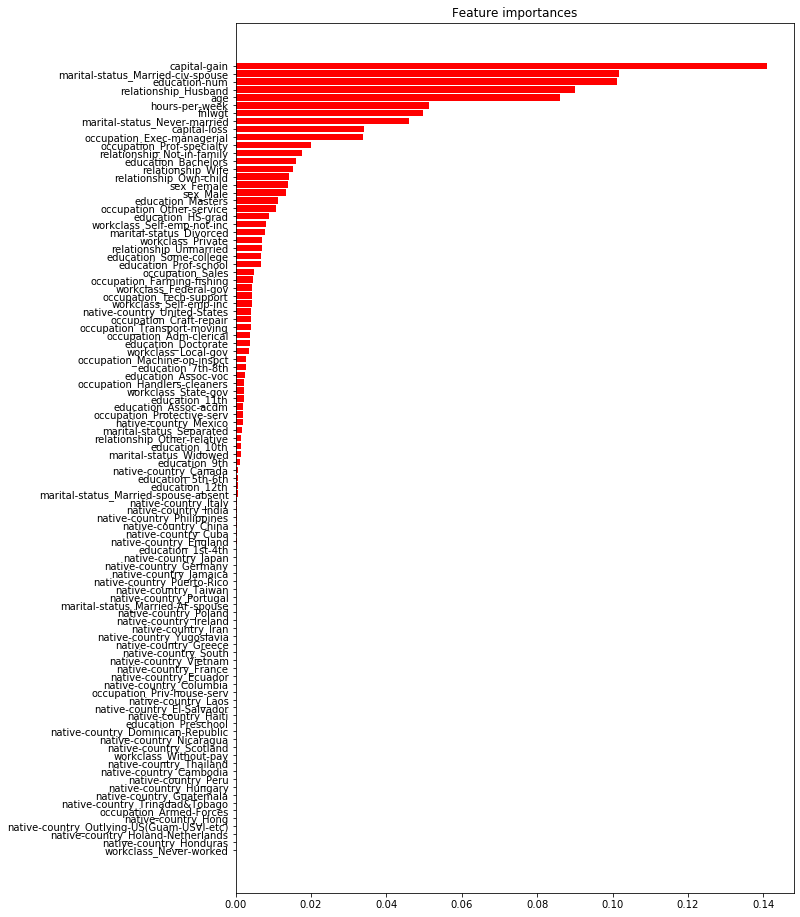

In [125]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(nopp_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

### Model: Extra Trees

In [57]:
## FINAL MODEL
best_params = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True,
    'random_state': RAND_STATE
}
et = ExtraTreesClassifier(**best_params)

p_alltrain, p_test = runL0Model(et, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename="stack2/nopp_et1.pkl",
                                proba_filename="stack2/nopp_et1.pkl")

printCVResults("stack2/nopp_et1.pkl")

(24421, 103)
(24421,)
(24421, 103)
Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.85005, F1 = 0.64802

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/nopp_et1.pkl
Saving CV predictions to: dump/log/nopp_et1.pkl
Train set:
[[14051   797]
 [ 1810  2878]]
Accuracy = 0.86655, F1 = 0.68827
Validation set:
[[3507  205]
 [ 508  665]]
Accuracy = 0.85404, F1 = 0.65100

Train set:
[[14053   795]
 [ 1828  2861]]
Accuracy = 0.86574, F1 = 0.68568
Validation set:
[[3479  233]
 [ 499  673]]
Accuracy = 0.85012, F1 = 0.64774

Train set:
[[14062   786]
 [ 1813  2876]]
Accuracy = 0.86697, F1 = 0.68878
Validation set:
[[3480  232]
 [ 525  647]]
Accuracy = 0.84500, F1 = 0.63091

Train set:
[[14019   829]
 [ 1786  2903]]
Accuracy = 0.86615, F1 = 0.68947
Validation set:
[[3471  241]
 [ 492  680]]
Accuracy = 0.84992, F1 = 0.64978

Train set:
[[14013   835]
 [ 1781  2908]]
Accuracy = 0.8

In [59]:
## FINAL MODEL
# IMPORT DATA
best_params = {
    'n_estimators': 150,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 56,
    'bootstrap': True,
    'class_weight': 'balanced_subsample',
    'random_state': RAND_STATE
}
et = ExtraTreesClassifier(**best_params)

p_alltrain, p_test = runL0Model(et, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename="stack2/nopp_et2.pkl",
                                proba_filename="stack2/nopp_et2.pkl")

printCVResults("stack2/nopp_et2.pkl")

(24421, 103)
(24421,)
(24421, 103)
Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.80595, F1 = 0.67472

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/nopp_et2.pkl
Saving CV predictions to: dump/log/nopp_et2.pkl
Train set:
[[12002  2846]
 [  498  4190]]
Accuracy = 0.82883, F1 = 0.71477
Validation set:
[[2999  713]
 [ 200  973]]
Accuracy = 0.81310, F1 = 0.68066

Train set:
[[11953  2895]
 [  493  4196]]
Accuracy = 0.82659, F1 = 0.71239
Validation set:
[[2961  751]
 [ 190  982]]
Accuracy = 0.80733, F1 = 0.67608

Train set:
[[11983  2865]
 [  501  4188]]
Accuracy = 0.82771, F1 = 0.71334
Validation set:
[[2937  775]
 [ 197  975]]
Accuracy = 0.80098, F1 = 0.66735

Train set:
[[12018  2830]
 [  519  4170]]
Accuracy = 0.82858, F1 = 0.71349
Validation set:
[[2937  775]
 [ 192  980]]
Accuracy = 0.80201, F1 = 0.66963

Train set:
[[12053  2795]
 [  517  4172]]
Accuracy = 0.8

In [ ]:
## GRID SEARCH
# Fixed parameters
params_et = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': RAND_STATE
}
et = ExtraTreesClassifier(**params_et)
    
# Search grid
params_grid = {
    'n_estimators': [100, 500, 2500, 5000, 10000],
    'max_depth': [3, 6, 12, 24, 48],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10, 20],
    'max_samples': [0.8, 0.9, None],
    'class_weight': [None, 'balanced_subsample']
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 1800,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# # Fit parameters
# params_fit = {
#     'cat_features': list(range(4,11)),
#     'verbose': 100
# }

results_dict = runRandSearchCV(et, params_grid, params_search,
                               nopp_alltrain, y_alltrain,
                               "nopp_et.pkl")

1800
Number of all possible combinations: 1800
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  5.0min


In [50]:
## LOAD PARAMS
PARAMS_RPATH = 'dump/params/nopp_et.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'n_estimators': 2500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': None, 'max_depth': 48, 'class_weight': None}
Training accuracy: 87.023 +/- 0.151%
Validation accuracy: 84.878 +/- 0.371%

Best params (F1): {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': None, 'max_depth': 48, 'class_weight': 'balanced_subsample'}
Training F1: 72.260 +/- 0.301%
Validation F1: 67.488 +/- 0.193%
Training accuracy: 83.457 +/- 0.220%
Validation accuracy: 80.685 +/- 0.059%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'n_estimators': 100, 'min_samples_split': 5, ...",1218,0.765356,0.764997,0.044113,0.041205
1,"{'n_estimators': 500, 'min_samples_split': 5, ...",1207,0.765325,0.765038,0.043424,0.041044
2,"{'n_estimators': 2500, 'min_samples_split': 5,...",1255,0.764844,0.764629,0.039596,0.037773
3,"{'n_estimators': 5000, 'min_samples_split': 5,...",1317,0.764752,0.764342,0.038776,0.035502
4,"{'n_estimators': 10000, 'min_samples_split': 5...",1360,0.764045,0.763810,0.033104,0.031208
...,...,...,...,...,...,...
1795,"{'n_estimators': 100, 'min_samples_split': 20,...",1000,0.779329,0.775439,0.651168,0.644789
1796,"{'n_estimators': 500, 'min_samples_split': 20,...",991,0.778633,0.775562,0.650358,0.645142
1797,"{'n_estimators': 2500, 'min_samples_split': 20...",1015,0.778725,0.775316,0.650340,0.644901
1798,"{'n_estimators': 5000, 'min_samples_split': 20...",997,0.779032,0.775439,0.650712,0.644889


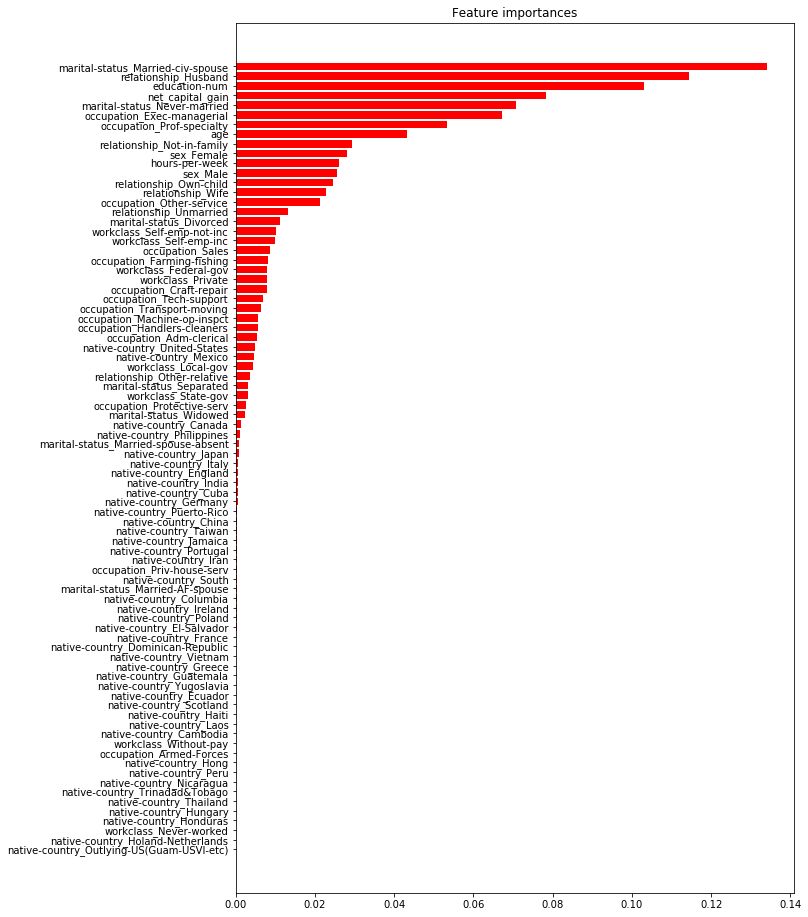

In [31]:
# ExtraTrees feature selection
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(X_train)

# for i in indices[:10]:
#     print("{}: {:.5f}".format(colnames[i], importances[i]))
    
# Plot the feature importances of the forest
fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
# plt.xlim([-1, X.shape[1]])
plt.show()

### Model: XGBoost

In [19]:
## FINAL MODEL
best_params = {
    'objective': 'binary:logistic',
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'num_leaves': 50,
    'max_depth': 6,
    'min_child_weight': 2,
    'scale_pos_weight': 1
}
xgb = XGBClassifier(**best_params)

p_alltrain, p_test = runL0Model(xgb, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_xgb1.pkl',
                                proba_filename='stack2/nopp_xgb1.pkl')
printCVResults('stack2/nopp_xgb1.pkl')

(24421, 103)
(24421,)
(24421, 103)
Fold 0 is completed!
Fold 1 is completed!
Fold 2 is completed!
Fold 3 is completed!
Fold 4 is completed!
Consolidated validation folds:
Accuracy = 0.87232, F1 = 0.70695

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/nopp_xgb1.pkl
Saving CV predictions to: dump/log/stack2/nopp_xgb1.pkl
Train set:
[[14158   690]
 [ 1556  3132]]
Accuracy = 0.88503, F1 = 0.73608
Validation set:
[[3542  170]
 [ 433  740]]
Accuracy = 0.87656, F1 = 0.71051

Train set:
[[14181   667]
 [ 1530  3159]]
Accuracy = 0.88755, F1 = 0.74198
Validation set:
[[3502  210]
 [ 417  755]]
Accuracy = 0.87162, F1 = 0.70660

Train set:
[[14157   691]
 [ 1533  3156]]
Accuracy = 0.88616, F1 = 0.73946
Validation set:
[[3507  205]
 [ 444  728]]
Accuracy = 0.86712, F1 = 0.69169

Train set:
[[14155   693]
 [ 1553  3136]]
Accuracy = 0.88504, F1 = 0.73632
Validation set:
[[3509  203]
 [ 416  756]]
Accuracy = 0.87326, F1 = 0.70953

Train set:
[[14150   698]

In [22]:
## FINAL MODEL
best_params = {
    'objective': 'binary:logistic',
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'num_leaves': 50,
    'max_depth': 6,
    'min_child_weight': 2,
    'scale_pos_weight': 1.5
}
xgb = XGBClassifier(**best_params)

p_alltrain, p_test = runL0Model(xgb, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_xgb2.pkl',
                                proba_filename='stack2/nopp_xgb2.pkl')
printCVResults('stack2/nopp_xgb2.pkl')

(24421, 103)
(24421,)
(24421, 103)
Fold 0 is completed!
Fold 1 is completed!
Fold 2 is completed!
Fold 3 is completed!
Fold 4 is completed!
Consolidated validation folds:
Accuracy = 0.86999, F1 = 0.72967

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/nopp_xgb2.pkl
Saving CV predictions to: dump/log/stack2/nopp_xgb2.pkl
Train set:
[[13697  1151]
 [ 1119  3569]]
Accuracy = 0.88380, F1 = 0.75872
Validation set:
[[3416  296]
 [ 321  852]]
Accuracy = 0.87369, F1 = 0.73417

Train set:
[[13737  1111]
 [ 1095  3594]]
Accuracy = 0.88709, F1 = 0.76517
Validation set:
[[3387  325]
 [ 310  862]]
Accuracy = 0.86998, F1 = 0.73082

Train set:
[[13730  1118]
 [ 1108  3581]]
Accuracy = 0.88606, F1 = 0.76289
Validation set:
[[3400  312]
 [ 336  836]]
Accuracy = 0.86732, F1 = 0.72069

Train set:
[[13664  1184]
 [ 1071  3618]]
Accuracy = 0.88458, F1 = 0.76241
Validation set:
[[3396  316]
 [ 312  860]]
Accuracy = 0.87142, F1 = 0.73254

Train set:
[[13710  1138]

In [ ]:
## FINAL MODEL
# IMPORT DATA
DATA_RPATH = "dump/data/nopp.pkl"
with open(DATA_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)

print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

best_params = {
    'objective': 'binary:logistic',
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'num_leaves': 50,
    'max_depth': 6,
    'min_child_weight': 2,
    'scale_pos_weight': 1.2
}
xgb = XGBClassifier(**best_params)

p_alltrain, p_test = runL0Model(xgb, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_xgb2.pkl',
                                proba_filename='stack2/nopp_xgb2.pkl')
printCVResults('stack2/nopp_xgb2.pkl')

#### Evaluating datasets

In [66]:
# IMPORT DATA
DATA_RPATH = "dump/data/raw2a.pkl"
with open(DATA_RPATH, "rb") as f:
    raw2a_alltrain, y_alltrain, raw2a_test = pkl.load(f)

print(raw2a_alltrain.shape)
print(y_alltrain.shape)
print(raw2a_test.shape)

params_xgb = {
    'booster': 'gbtree',
    'max_depth': 5,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_estimators': 1000
}
xgb = XGBClassifier()

p_alltrain = runL0Model(xgb, raw2a_alltrain, y_alltrain,
                        cv_filename="xgb_foo.pkl",
                        algorithm="xgb",
                        verbose=100)

# ypred_test = (p_test > 0.5).astype(int)
# saveResult(ypred_test, "raw2a-xgb_hanae.csv")

(24421, 86)
(24421,)
(24421, 86)
Fold 0
[0]	validation_0-error:0.14166
Will train until validation_0-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[43]	validation_0-error:0.12569

Train set:
[[14146   702]
 [ 1458  3230]]
Accuracy = 0.88943, F1 = 0.74942
Validation set:
[[3526  186]
 [ 428  745]]
Accuracy = 0.87431, F1 = 0.70817

Fold 1
[0]	validation_0-error:0.14763
Will train until validation_0-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[30]	validation_0-error:0.12776

Train set:
[[14160   688]
 [ 1542  3147]]
Accuracy = 0.88586, F1 = 0.73839
Validation set:
[[3503  209]
 [ 415  757]]
Accuracy = 0.87224, F1 = 0.70814

Fold 2
[0]	validation_0-error:0.14742
Will train until validation_0-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[21]	validation_0-error:0.13022

Train set:
[[14146   702]
 [ 1589  3100]]
Accuracy = 0.88274, F1 = 0.73018
Validation set:
[[3517  195]
 [ 441  731]]
Accuracy = 0.86978, F1 = 0.69685

Fold 3
[0]	validation_

In [5]:
## GRID SEARCH
# Fixed parameters
params_xgb = {
    'booster': 'gbtree',
    'num_leaves': 50,
    'objective': 'binary:logistic',
    'random_seed': RAND_STATE
}
xgb = XGBClassifier(**params_xgb)

# Search grid
params_grid = {
    'n_estimators': [100, 300, 500, 1000, 2000, 5000],
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [6, 8, 10, 12, 24],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 1]
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 540,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# # Fit parameters
# params_fit = {
#     'cat_features': list(range(4,11)),
#     'verbose': 100
# }

results_dict = runRandSearchCV(xgb, params_grid, params_search,
                               nopp_alltrain, y_alltrain,
                               "nopp_xgb.pkl")

540


In [4]:
## LOAD PARAMS
PARAMS_RPATH = 'nopp_xgb.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'iterations': 100}
Training accuracy: 90.330 +/- 0.192%
Validation accuracy: 87.122 +/- 0.524%

Best params (F1): {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'iterations': 100}
Training F1: 78.419 +/- 0.429%
Validation F1: 71.125 +/- 1.518%
Training accuracy: 90.330 +/- 0.192%
Validation accuracy: 87.122 +/- 0.524%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'subsample': 0.8, 'min_child_weight': 1, 'max...",50,0.918308,0.867819,0.819505,0.703623
1,"{'subsample': 0.9, 'min_child_weight': 1, 'max...",8,0.915503,0.870849,0.812923,0.711075
2,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",15,0.910917,0.870358,0.801713,0.708207
3,"{'subsample': 0.8, 'min_child_weight': 2, 'max...",85,0.913660,0.866836,0.808561,0.701767
4,"{'subsample': 0.9, 'min_child_weight': 2, 'max...",43,0.913804,0.868351,0.809239,0.706700
...,...,...,...,...,...,...
373,"{'subsample': 0.9, 'min_child_weight': 2, 'max...",253,0.999877,0.858524,0.999744,0.688064
374,"{'subsample': 1.0, 'min_child_weight': 2, 'max...",260,0.999877,0.858524,0.999744,0.687797
375,"{'subsample': 0.8, 'min_child_weight': 5, 'max...",344,0.992271,0.856312,0.983743,0.683983
376,"{'subsample': 0.9, 'min_child_weight': 5, 'max...",330,0.995926,0.856353,0.991472,0.682958


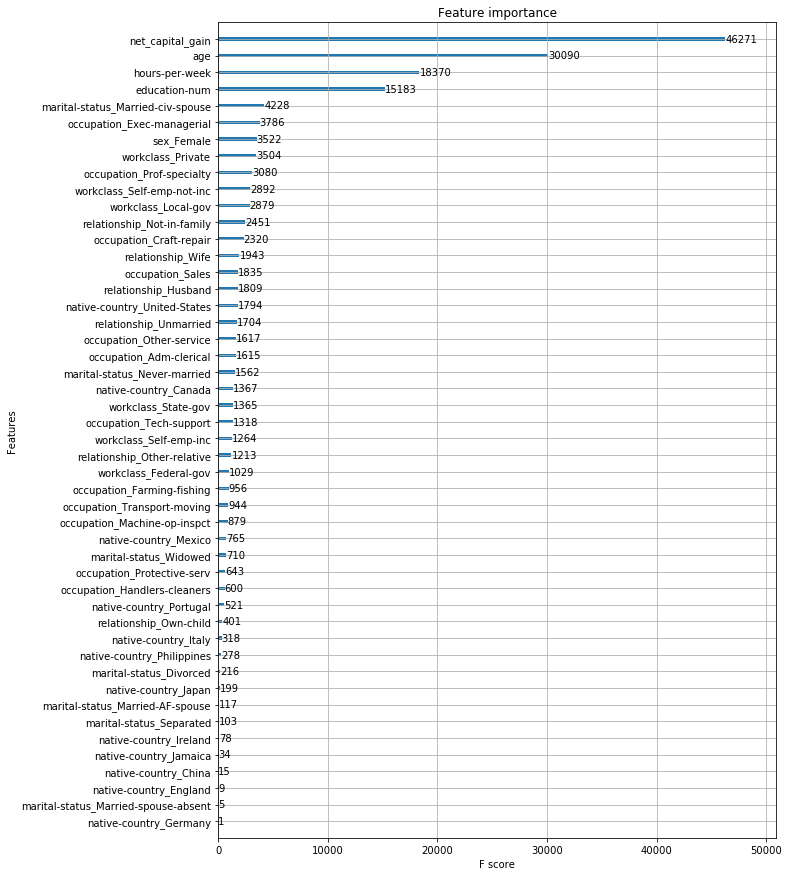

In [35]:
# # Feature importance
# print(xgb.feature_importances_)

# Built in function that uses F-scores to rank
fig, ax = plt.subplots(1, 1, figsize=(10,15))
plot_importance(xgb, ax=ax)
plt.show()

### Model: LightGBM

#### Evaluating datasets

In [7]:
# IMPORT DATA
DATA_RPATH = "dump/data/labelenc.pkl"
with open(DATA_RPATH, "rb") as f:
    labelenc_alltrain, y_alltrain, labelenc_test = pkl.load(f)

print(labelenc_alltrain.shape)
print(y_alltrain.shape)
print(labelenc_test.shape)
print(list(labelenc_alltrain))

(24421, 11)
(24421,)
(24421, 11)
['age', 'education-num', 'hours-per-week', 'net_capital_gain', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']


In [21]:
params_lgbm = {
    'boosting_type': 'gbdt',
    'num_leaves': 30,
    'max_depth': 10,
    'learning_rate': 0.01, # Increase n_estimators when reducing learning rate
    'n_estimators': 5000,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_data_in_leaf': 30,
    'bagging_freq': 4,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'random_state': RAND_STATE
}
lgbm = lgb.LGBMClassifier(**params_lgbm)

p_alltrain, p_test = runL0Model(lgbm, labelenc_alltrain, y_alltrain, labelenc_test,
                                algorithm="lgbm",
                                categorical_feature=list(range(4,11)),
                                verbose=500)

Fold 0
Training until validation scores don't improve for 10 rounds


/home/w/weixin/anaconda3/envs/keras-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5, 6, 7, 8, 9, 10]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[500]	valid_0's binary_logloss: 0.277048
Early stopping, best iteration is:
[686]	valid_0's binary_logloss: 0.273357
Train set:
[[14064   784]
 [ 1514  3174]]
Accuracy = 0.88237, F1 = 0.73421
Validation set:
[[3521  191]
 [ 416  757]]
Accuracy = 0.87574, F1 = 0.71381

Fold 1
Training until validation scores don't improve for 10 rounds
[500]	valid_0's binary_logloss: 0.285169
Early stopping, best iteration is:
[716]	valid_0's binary_logloss: 0.280668
Train set:
[[14085   763]
 [ 1465  3224]]
Accuracy = 0.88596, F1 = 0.74320
Validation set:
[[3487  225]
 [ 398  774]]
Accuracy = 0.87244, F1 = 0.71304

Fold 2
Training until validation scores don't improve for 10 rounds
[500]	valid_0's binary_logloss: 0.283029
Early stopping, best iteration is:
[603]	valid_0's binary_logloss: 0.280842
Train set:
[[14080   768]
 [ 1489  3200]]
Accuracy = 0.88448, F1 = 0.73929
Validation set:
[[3495  217]
 [ 417  755]]
Accuracy = 0.87019, F1 = 0.70429

Fold 3
Training until validation scores don't improve for

In [ ]:
best_params = {
    'reg_lambda': 100,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 10,
    'n_estimators': 10000,
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False
}
lgbm = lgb.LGBMClassifier(**best_params)

p_alltrain, p_test = runL0Model(lgbm, nopp_alltrain, y_alltrain, nopp_test,
                                "nopp-lgbm_hanae.pkl")
ypred_test = (p_test > 0.5).astype(int)
saveResult(ypred_test, "nopp-lgbm_hanae.csv")

Fold 0
Train set:
[[14043   805]
 [ 1499  3189]]
Accuracy = 0.88206, F1 = 0.73462
Validation set:
[[3512  200]
 [ 405  768]]
Accuracy = 0.87615, F1 = 0.71742

Fold 1
Train set:
[[14034   814]
 [ 1473  3216]]
Accuracy = 0.88294, F1 = 0.73770
Validation set:
[[3466  246]
 [ 395  777]]
Accuracy = 0.86876, F1 = 0.70797

Fold 2
Train set:
[[14053   795]
 [ 1475  3214]]
Accuracy = 0.88381, F1 = 0.73902
Validation set:
[[3489  223]
 [ 412  760]]
Accuracy = 0.86998, F1 = 0.70534

Fold 3
Train set:
[[14029   819]
 [ 1491  3198]]
Accuracy = 0.88176, F1 = 0.73467
Validation set:
[[3490  222]
 [ 390  782]]
Accuracy = 0.87469, F1 = 0.71875

Fold 4
Train set:
[[14050   798]
 [ 1497  3192]]
Accuracy = 0.88253, F1 = 0.73557
Validation set:
[[3473  239]
 [ 361  811]]
Accuracy = 0.87715, F1 = 0.72997

Consolidated validation folds:
Accuracy = 0.87335, F1 = 0.71595

p_alltrain: (24421,)


In [ ]:
# IMPORT DATA
DATA_RPATH = "dump/data/raw2a.pkl"
with open(DATA_RPATH, "rb") as f:
    raw2a_alltrain, y_alltrain, raw2a_test = pkl.load(f)

print(raw2a_alltrain.shape)
print(y_alltrain.shape)
print(raw2a_test.shape)
print(list(raw2a_alltrain))

best_params = {
    'reg_lambda': 100,
    'reg_alpha': 0.1,
    'objective': 'binary',
    'num_leaves': 10,
    'n_estimators': 10000,
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'max_bin': 50,
    'learning_rate': 0.01,
    'dart': False,
    'bootstrap': False
}
lgbm = lgb.LGBMClassifier(**best_params)

p_alltrain, p_test = runL0Model(lgbm, raw2a_alltrain, y_alltrain, raw2a_test,
                                "raw2a-lgbm_hanae_earlystop.pkl",
                                algorithm="lgbm",
                                verbose=500)
ypred_test = (p_test > 0.5).astype(int)
saveResult(ypred_test, "raw2a-lgbm_hanae_earlystop.csv")

In [ ]:
## GRID SEARCH
# Fixed parameters
params_lgbm = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_seed': RAND_STATE
}
lgbm = lgb.LGBMClassifier(**params_lgbm)

# Search grid
params_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'iterations': [100, 500, 1000, 2000, 5000, 10000],
    'learning_rate': [0.1, 0.01],
    'max_depth': [6, 12, 24, 48],
    'min_data_in_leaf': [5, 10, 20],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1, 10],
    'class_weight': ['balanced', None]
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 1500,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# # # Fit parameters
# # params_fit = {
# #     'cat_features': list(range(4,11)),
# #     'verbose': 100
# # }

results_dict = runRandSearchCV(lgbm, params_grid, params_search,
                               nopp_alltrain, y_alltrain,
                               "nopp_lgbm.pkl")

20736
Number of all possible combinations: 20736
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  6.5min


In [46]:
## LOAD PARAMS
PARAMS_RPATH = 'dump/params/nopp_lgbm.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'reg_lambda': 1, 'reg_alpha': 1, 'min_data_in_leaf': 20, 'max_depth': 12, 'learning_rate': 0.1, 'iterations': 1000, 'class_weight': None, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9}
Training accuracy: 88.978 +/- 0.087%
Validation accuracy: 87.347 +/- 0.435%

Best params (F1): {'reg_lambda': 0, 'reg_alpha': 0, 'min_data_in_leaf': 5, 'max_depth': 12, 'learning_rate': 0.1, 'iterations': 10000, 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'bagging_fraction': 0.8}
Training F1: 75.899 +/- 0.204%
Validation F1: 71.730 +/- 0.351%
Training accuracy: 86.084 +/- 0.168%
Validation accuracy: 83.698 +/- 0.172%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'reg_lambda': 1, 'reg_alpha': 1, 'min_data_in...",34,0.890013,0.873060,0.752856,0.714940
1,"{'reg_lambda': 1, 'reg_alpha': 1, 'min_data_in...",292,0.878496,0.869129,0.722226,0.700595
2,"{'reg_lambda': 0.1, 'reg_alpha': 1, 'min_data_...",300,0.878670,0.868638,0.722765,0.699461
3,"{'reg_lambda': 0.1, 'reg_alpha': 0, 'min_data_...",1255,0.818804,0.812129,0.698290,0.687397
4,"{'reg_lambda': 10, 'reg_alpha': 0.1, 'min_data...",514,0.854398,0.852504,0.601651,0.595978
...,...,...,...,...,...,...
1495,"{'reg_lambda': 1, 'reg_alpha': 1, 'min_data_in...",292,0.878496,0.869129,0.722226,0.700595
1496,"{'reg_lambda': 0, 'reg_alpha': 1, 'min_data_in...",451,0.855688,0.852914,0.605861,0.598095
1497,"{'reg_lambda': 0, 'reg_alpha': 0, 'min_data_in...",843,0.860643,0.835961,0.758488,0.715214
1498,"{'reg_lambda': 0.1, 'reg_alpha': 0, 'min_data_...",132,0.886491,0.872200,0.741614,0.707415


In [47]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)
    
print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

## INSTANTIATE MODEL
params_lgbm = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_seed': RAND_STATE
}

params_lgbm.update(params_acc) # Append best params
for parameter, value in params_lgbm.items():
    print(parameter, "=", value)

lgbm = lgb.LGBMClassifier(**params_lgbm)

p_alltrain, p_test = runL0Model(lgbm, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_lgbm1.pkl',
                                proba_filename='stack2/nopp_lgbm1.pkl')

printCVResults("stack2/nopp_lgbm1.pkl")

(24421, 103)
(24421,)
(24421, 103)
bootstrap = True
n_jobs = -1
random_seed = 0
reg_lambda = 1
reg_alpha = 1
min_data_in_leaf = 20
max_depth = 12
learning_rate = 0.1
iterations = 1000
class_weight = None
boosting_type = gbdt
bagging_fraction = 0.9
Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.87208, F1 = 0.71218

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/nopp_lgbm1.pkl
Saving CV predictions to: dump/log/stack2/nopp_lgbm1.pkl
Train set:
[[14116   732]
 [ 1442  3246]]
Accuracy = 0.88872, F1 = 0.74913
Validation set:
[[3518  194]
 [ 420  753]]
Accuracy = 0.87431, F1 = 0.71038

Train set:
[[14134   714]
 [ 1422  3267]]
Accuracy = 0.89067, F1 = 0.75363
Validation set:
[[3484  228]
 [ 401  771]]
Accuracy = 0.87121, F1 = 0.71027

Train set:
[[14120   728]
 [ 1415  3274]]
Accuracy = 0.89031, F1 = 0.75342
Validation set:
[[3490  222]
 [ 419  753]]
Accuracy = 

In [49]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)
    
print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

## INSTANTIATE MODEL
params_lgbm = {
    'bootstrap': True,
    'n_jobs': -1,
    'random_seed': RAND_STATE
}

params_lgbm.update(params_f1) # Append best params
for parameter, value in params_lgbm.items():
    print(parameter, "=", value)

lgbm = lgb.LGBMClassifier(**params_lgbm)

p_alltrain, p_test = runL0Model(lgbm, nopp_alltrain, y_alltrain, nopp_test,
                                cv_filename='stack2/nopp_lgbm2.pkl',
                                proba_filename='stack2/nopp_lgbm2.pkl')

printCVResults("stack2/nopp_lgbm2.pkl")

(24421, 103)
(24421,)
(24421, 103)
bootstrap = True
n_jobs = -1
random_seed = 0
reg_lambda = 0
reg_alpha = 0
min_data_in_leaf = 5
max_depth = 12
learning_rate = 0.1
iterations = 10000
class_weight = balanced
boosting_type = gbdt
bagging_fraction = 0.8
Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.83629, F1 = 0.71589

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/nopp_lgbm2.pkl
Saving CV predictions to: dump/log/stack2/nopp_lgbm2.pkl
Train set:
[[12541  2307]
 [  423  4265]]
Accuracy = 0.86026, F1 = 0.75755
Validation set:
[[3120  592]
 [ 167 1006]]
Accuracy = 0.84463, F1 = 0.72609

Train set:
[[12540  2308]
 [  406  4283]]
Accuracy = 0.86108, F1 = 0.75940
Validation set:
[[3103  609]
 [ 173  999]]
Accuracy = 0.83989, F1 = 0.71871

Train set:
[[12563  2285]
 [  419  4270]]
Accuracy = 0.86160, F1 = 0.75952
Validation set:
[[3056  656]
 [ 164 1008]]
Accurac

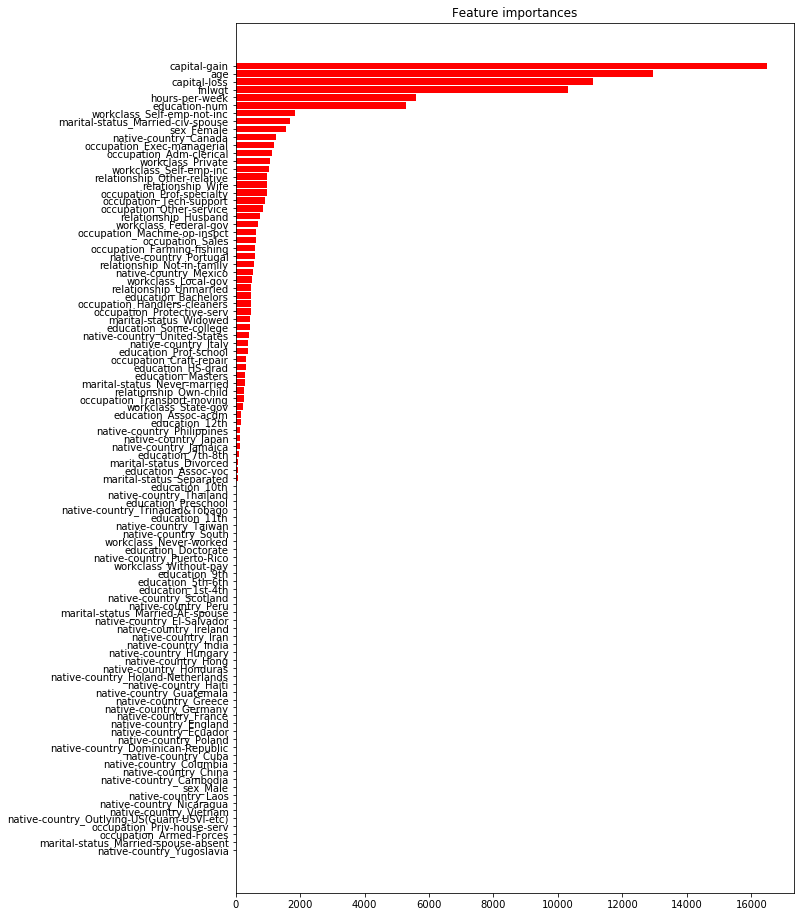

In [113]:
importances = lgbm1.feature_importances_
indices = np.argsort(importances)[::-1]
colnames = list(nopp_train)

fig, ax = plt.subplots(1, 1, figsize=(10,16))
ax.set_title("Feature importances")
ax.barh(range(len(colnames)), importances[indices[::-1]],
        color="r", align="center")
ax.set_yticks(range(len(colnames)))
ax.set_yticklabels(np.array(colnames)[indices][::-1])
plt.show()

### Model: CatBoost

In [12]:
# IMPORT DATA
DATA_RPATH = "dump/data/raw1.pkl"
with open(DATA_RPATH, "rb") as f:
    raw1_alltrain, y_alltrain, raw1_test = pkl.load(f)

print(raw1_alltrain.shape)
print(y_alltrain.shape)
print(raw1_test.shape)
raw1_alltrain.head()

(24421, 11)
(24421,)
(24421, 11)


,age,education-num,hours-per-week,net_capital_gain,workclass,fnlwgt,marital-status,occupation,relationship,sex,native-country
0,30,10,30,0,Others,147215,Never-married,Others,Own-child,Female,United-States
1,60,13,42,0,Private,173960,Divorced,Prof-specialty,Not-in-family,Female,United-States
2,52,10,12,0,Others,105428,Married-civ-spouse,Others,Husband,Male,United-States
3,37,13,60,0,Private,112497,Married-civ-spouse,Sales,Husband,Male,United-States
4,63,10,48,7298,Private,137843,Married-civ-spouse,Sales,Husband,Male,United-States


In [114]:
## FROM FIRST SEARCH
params_catboost3 = {
    'iterations': 700, # n_estimators
    'depth': 6,
    'l2_leaf_reg': 1,
    'scale_pos_weight': 1,
    'random_seed': RAND_STATE
}

params_catboost4 = {
    'iterations': 1000, # n_estimators
    'depth': 6,
    'l2_leaf_reg': 1,
    'scale_pos_weight': 2,
    'random_seed': RAND_STATE
}

catboost = CatBoostClassifier(**params_catboost3)
cat_idx = [4,6,7,8,9,10]
p_alltrain, p_test = runL0Model(catboost, raw1_alltrain, y_alltrain, raw1_test,
                                cv_filename='stack2/raw1_catboost3.pkl',
                                proba_filename='stack2/raw1_catboost3.pkl',
                                cat_features=cat_idx,
                                verbose=100)

printCVResults("stack2/raw1_catboost3.pkl")

0:	learn: 0.6583948	total: 36.7ms	remaining: 25.7s
100:	learn: 0.2985274	total: 2.73s	remaining: 16.2s
200:	learn: 0.2830702	total: 5.52s	remaining: 13.7s
300:	learn: 0.2745535	total: 8.21s	remaining: 10.9s
400:	learn: 0.2663488	total: 11s	remaining: 8.23s
500:	learn: 0.2597682	total: 13.8s	remaining: 5.48s
600:	learn: 0.2545546	total: 16.6s	remaining: 2.74s
699:	learn: 0.2500997	total: 19.4s	remaining: 0us
Fold 0 is completed!
0:	learn: 0.6624069	total: 33.1ms	remaining: 23.2s
100:	learn: 0.2967488	total: 3.29s	remaining: 19.5s
200:	learn: 0.2816606	total: 6.11s	remaining: 15.2s
300:	learn: 0.2728080	total: 9.51s	remaining: 12.6s
400:	learn: 0.2648390	total: 12.7s	remaining: 9.46s
500:	learn: 0.2585359	total: 15.5s	remaining: 6.14s
600:	learn: 0.2540020	total: 18.1s	remaining: 2.98s
699:	learn: 0.2500589	total: 20.8s	remaining: 0us
Fold 1 is completed!
0:	learn: 0.6605880	total: 52.6ms	remaining: 36.8s
100:	learn: 0.2981495	total: 3.68s	remaining: 21.8s
200:	learn: 0.2807236	total: 7.

In [115]:
## FROM FIRST SEARCH
params_catboost3 = {
    'iterations': 700, # n_estimators
    'depth': 6,
    'l2_leaf_reg': 1,
    'scale_pos_weight': 1,
    'random_seed': RAND_STATE
}

params_catboost4 = {
    'iterations': 1000, # n_estimators
    'depth': 6,
    'l2_leaf_reg': 1,
    'scale_pos_weight': 2,
    'random_seed': RAND_STATE
}

catboost = CatBoostClassifier(**params_catboost4)
cat_idx = [4,6,7,8,9,10]
p_alltrain, p_test = runL0Model(catboost, raw1_alltrain, y_alltrain, raw1_test,
                                cv_filename='stack2/raw1_catboost4.pkl',
                                proba_filename='stack2/raw1_catboost4.pkl',
                                cat_features=cat_idx,
                                verbose=100)

printCVResults("stack2/raw1_catboost4.pkl")

0:	learn: 0.6675523	total: 46.9ms	remaining: 46.8s
100:	learn: 0.3543161	total: 3.02s	remaining: 26.9s
200:	learn: 0.3339681	total: 5.79s	remaining: 23s
300:	learn: 0.3234703	total: 8.42s	remaining: 19.6s
400:	learn: 0.3130434	total: 11.3s	remaining: 16.9s
500:	learn: 0.3038336	total: 14s	remaining: 14s
600:	learn: 0.2969166	total: 16.7s	remaining: 11.1s
700:	learn: 0.2911028	total: 19.8s	remaining: 8.45s
800:	learn: 0.2858149	total: 23s	remaining: 5.71s
900:	learn: 0.2807426	total: 26.8s	remaining: 2.95s
999:	learn: 0.2762475	total: 30.6s	remaining: 0us
Fold 0 is completed!
0:	learn: 0.6687727	total: 41.1ms	remaining: 41s
100:	learn: 0.3506065	total: 3.65s	remaining: 32.5s
200:	learn: 0.3314639	total: 6.94s	remaining: 27.6s
300:	learn: 0.3208947	total: 11.2s	remaining: 26s
400:	learn: 0.3096160	total: 14s	remaining: 20.9s
500:	learn: 0.3012673	total: 16.9s	remaining: 16.8s
600:	learn: 0.2952936	total: 21.3s	remaining: 14.1s
700:	learn: 0.2900252	total: 24.1s	remaining: 10.3s
800:	lear

In [113]:
## FROM FIRST SEARCH
params_catboost3 = {
    'iterations': 700, # n_estimators
    'depth': 6,
    'l2_leaf_reg': 1,
    'scale_pos_weight': 1,
    'one_hot_max_size': 100,
    'random_seed': RAND_STATE
}

catboost = CatBoostClassifier(**params_catboost3)
cat_idx = [4,6,7,8,9,10]

p_alltrain = runL0Model(catboost, raw1_alltrain, y_alltrain,
                                cv_filename='raw1_catboost3_onehot.pkl',
                                cat_features=cat_idx,
                                verbose=100)

printCVResults("raw1_catboost3_onehot.pkl")

0:	learn: 0.6631185	total: 32.5ms	remaining: 22.7s
100:	learn: 0.3001779	total: 2.41s	remaining: 14.3s
200:	learn: 0.2835457	total: 4.79s	remaining: 11.9s
300:	learn: 0.2742971	total: 7.26s	remaining: 9.63s
400:	learn: 0.2647728	total: 9.62s	remaining: 7.17s
500:	learn: 0.2570218	total: 12.1s	remaining: 4.8s
600:	learn: 0.2505941	total: 14.4s	remaining: 2.38s
699:	learn: 0.2454096	total: 17s	remaining: 0us
Fold 0 is completed!
0:	learn: 0.6641676	total: 27.8ms	remaining: 19.5s
100:	learn: 0.2983136	total: 2.65s	remaining: 15.7s
200:	learn: 0.2812232	total: 5.32s	remaining: 13.2s
300:	learn: 0.2713713	total: 8.75s	remaining: 11.6s
400:	learn: 0.2617671	total: 11.6s	remaining: 8.68s
500:	learn: 0.2543551	total: 14.1s	remaining: 5.61s
600:	learn: 0.2485615	total: 16.6s	remaining: 2.74s
699:	learn: 0.2433578	total: 19.3s	remaining: 0us
Fold 1 is completed!
0:	learn: 0.6628821	total: 31.7ms	remaining: 22.2s
100:	learn: 0.2992462	total: 2.54s	remaining: 15.1s
200:	learn: 0.2805126	total: 5.1

In [ ]:
## GRID SEARCH
# Fixed parameters
params_catboost = {
    'random_seed': RAND_STATE
}
catboost = CatBoostClassifier(**params_catboost)

# Search grid
params_grid = {
    'iterations': [100, 300, 500, 700, 1000, 2500, 5000, 10000],
    'depth': [6, 8, 10, 12, 24, 48],
    'l2_leaf_reg': [1, 3, 5],
    'grow_policy': ['SymmetricTree', 'Depthwise', None],
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 432,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

# Fit parameters
cat_idx = [4,6,7,8,9,10]
params_fit = {
    'cat_features': cat_idx,
    'verbose': 100
}

results_dict = runRandSearchCV(catboost, params_grid, params_search,
                               raw1_alltrain, y_alltrain,
                               "stack2/raw1_catboost1.pkl", params_fit=params_fit)

432
Number of all possible combinations: 432
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.4s


In [33]:
## LOAD PARAMS
PARAMS_RPATH = 'raw1_catboost.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'scale_pos_weight': 1.0, 'iterations': 700}
Training accuracy: 89.697 +/- 0.530%
Validation accuracy: 87.367 +/- 0.451%

Best params (F1): {'scale_pos_weight': 2.0, 'iterations': 1000}
Training F1: 78.310 +/- 0.514%
Validation F1: 73.107 +/- 0.721%
Training accuracy: 88.772 +/- 0.174%
Validation accuracy: 86.250 +/- 0.258%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'scale_pos_weight': 3.0, 'iterations': 1000}",16,0.868771,0.843618,0.766299,0.721702
1,"{'scale_pos_weight': 2.0, 'iterations': 1000}",10,0.887720,0.862495,0.783096,0.731073
2,"{'scale_pos_weight': 2.0, 'iterations': 2500}",12,0.893289,0.862209,0.791670,0.729468
3,"{'scale_pos_weight': 2.0, 'iterations': 1500}",13,0.891221,0.862045,0.788427,0.729517
4,"{'scale_pos_weight': 1.0, 'iterations': 2500}",3,0.896708,0.872569,0.767453,0.707459
5,"{'scale_pos_weight': 1.5, 'iterations': 500}",8,0.894220,0.869457,0.780717,0.726378
6,"{'scale_pos_weight': 1.5, 'iterations': 1500}",6,0.896564,0.870153,0.786322,0.727284
7,"{'scale_pos_weight': 3.0, 'iterations': 2500}",15,0.871217,0.844683,0.770704,0.723370
8,"{'scale_pos_weight': 1.0, 'iterations': 2000}",2,0.896360,0.872855,0.767153,0.708550
9,"{'scale_pos_weight': 1.0, 'iterations': 1000}",4,0.897035,0.872364,0.768874,0.707138


In [29]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/raw1.pkl"
with open(TRAIN_RPATH, "rb") as f:
    raw1_alltrain, y_alltrain, raw1_test = pkl.load(f)
    
print(raw1_alltrain.shape)
print(y_alltrain.shape)
print(raw1_test.shape)

## INSTANTIATE MODEL
params_catboost = {
    'random_seed': RAND_STATE
}

params_catboost.update(params_acc) # Append best params
for parameter, value in params_catboost.items():
    print(parameter, "=", value)

cat_idx = [4,6,7,8,9,10]
catboost = CatBoostClassifier(**params_catboost)

p_alltrain, p_test = runL0Model(catboost, raw1_alltrain, y_alltrain, raw1_test,
                                cv_filename='raw1_catboost3.pkl',
                                proba_filename='raw1_catboost3.pkl',
                                cat_features=cat_idx,
                                verbose=100)

printCVResults("raw1_catboost3.pkl")

(24421, 11)
(24421,)
(24421, 11)
random_seed = 0
scale_pos_weight = 1.0
iterations = 700
Learning rate set to 0.050835
0:	learn: 0.6360183	total: 95.8ms	remaining: 1m 6s
100:	learn: 0.2872918	total: 8.53s	remaining: 50.6s
200:	learn: 0.2738149	total: 16.9s	remaining: 41.9s
300:	learn: 0.2625873	total: 25s	remaining: 33.1s
400:	learn: 0.2565683	total: 33.6s	remaining: 25.1s
500:	learn: 0.2498377	total: 42.6s	remaining: 16.9s
600:	learn: 0.2447401	total: 51.4s	remaining: 8.46s
699:	learn: 0.2397568	total: 1m	remaining: 0us
Fold 0 is completed!
Learning rate set to 0.050836
0:	learn: 0.6426196	total: 67.6ms	remaining: 47.2s
100:	learn: 0.2867400	total: 7.79s	remaining: 46.2s
200:	learn: 0.2727793	total: 16.4s	remaining: 40.7s
300:	learn: 0.2610185	total: 24.9s	remaining: 33s
400:	learn: 0.2539704	total: 33.5s	remaining: 25s
500:	learn: 0.2485965	total: 41.8s	remaining: 16.6s
600:	learn: 0.2437008	total: 50s	remaining: 8.23s
699:	learn: 0.2389752	total: 58.1s	remaining: 0us
Fold 1 is compl

In [34]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/raw1.pkl"
with open(TRAIN_RPATH, "rb") as f:
    raw1_alltrain, y_alltrain, raw1_test = pkl.load(f)
    
print(raw1_alltrain.shape)
print(y_alltrain.shape)
print(raw1_test.shape)

## INSTANTIATE MODEL
params_catboost = {
    'random_seed': RAND_STATE
}

params_catboost.update(params_f1) # Append best params
for parameter, value in params_catboost.items():
    print(parameter, "=", value)

cat_idx = [4,6,7,8,9,10]
catboost = CatBoostClassifier(**params_catboost)

p_alltrain, p_test = runL0Model(catboost, raw1_alltrain, y_alltrain, raw1_test,
                                cv_filename='raw1_catboost4.pkl',
                                proba_filename='raw1_catboost4.pkl',
                                cat_features=cat_idx,
                                verbose=100)

# printCVResults("raw1_catboost4.pkl")

(24421, 11)
(24421,)
(24421, 11)
random_seed = 0
scale_pos_weight = 2.0
iterations = 1000
Learning rate set to 0.036654
0:	learn: 0.6625428	total: 176ms	remaining: 2m 55s
100:	learn: 0.3489747	total: 9.52s	remaining: 1m 24s
200:	learn: 0.3328852	total: 18.1s	remaining: 1m 11s
300:	learn: 0.3222688	total: 26.5s	remaining: 1m 1s
400:	learn: 0.3125810	total: 35.6s	remaining: 53.2s
500:	learn: 0.3042917	total: 44.2s	remaining: 44.1s
600:	learn: 0.2972269	total: 54s	remaining: 35.8s
700:	learn: 0.2912862	total: 1m 2s	remaining: 26.9s
800:	learn: 0.2858811	total: 1m 12s	remaining: 17.9s
900:	learn: 0.2807889	total: 1m 20s	remaining: 8.8s
999:	learn: 0.2761348	total: 1m 28s	remaining: 0us
Fold 0 is completed!
Learning rate set to 0.036655
0:	learn: 0.6635742	total: 82.7ms	remaining: 1m 22s
100:	learn: 0.3454883	total: 8.16s	remaining: 1m 12s
200:	learn: 0.3282548	total: 16.7s	remaining: 1m 6s
300:	learn: 0.3174802	total: 25s	remaining: 58s
400:	learn: 0.3062261	total: 33.7s	remaining: 50.4s
5

In [51]:
## SAVE L0 MODEL PREDICTION
ypred_test = (p_test > 0.5).astype(int)
saveResult(ypred_test, "raw1_catboost.csv")

Saved submission file to: dump/submissions/raw1_catboost.csv


### Model: KNN

In [44]:
## IMPORT DATA
TRAIN_RPATH = "dump/data/wxpp1c.pkl"
with open(TRAIN_RPATH, "rb") as f:
    wxpp1c_alltrain, y_alltrain, wxpp1c_test = pkl.load(f)
    
print(wxpp1c_alltrain.shape)
print(y_alltrain.shape)
print(wxpp1c_test.shape)

(24421, 42)
(24421,)
(24421, 42)


In [121]:
## GRID SEARCH
# Fixed parameters
params_knn = {
    'n_jobs': -1
}
knn = KNeighborsClassifier(**params_knn)

# Search grid
params_grid = {
    'n_neighbors': [3,9,15,25,31,51,101], # Avoid even numbers
    'metric': ['euclidean', 'manhattan', 'canberra'],
}
print(getNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 24,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

runRandSearchCV(knn, params_grid, params_search,
                wxpp1c_alltrain, y_alltrain, "wxpp1c_knn.pkl")

30
Number of all possible combinations: 30
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.4s


Model fit duration: 00 h 06 min 39 s
Saved grid search results to: dump/params/wxpp1c_knn.pkl



[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.7min finished


{'mean_fit_time': array([ 3.30419626,  2.92485089,  3.94970965,  3.26804514,  5.60355706,
        13.36969023, 15.50865912, 21.15976658, 20.58354435, 13.52008686,
         7.75986843,  9.16313825, 12.94673986, 13.00976214,  9.48542485,
        13.21519818, 16.51547327, 16.59496613, 19.90094557, 18.00757709,
        14.96838493, 14.49176278, 12.33432903, 10.06449027]),
 'std_fit_time': array([1.3781569 , 1.01089586, 1.10343113, 1.47356511, 3.65712627,
        1.19691174, 0.99758272, 2.83082396, 1.41135193, 6.13630056,
        0.66424764, 0.57344157, 2.04433076, 2.5239798 , 1.34969756,
        2.21299228, 0.28547041, 0.53204621, 0.87841065, 2.71965845,
        1.99809961, 2.93813468, 0.33032754, 1.38202317]),
 'mean_score_time': array([ 6.06660814, 27.53434315,  9.31937518,  6.45118694, 27.92851977,
        39.88048306, 34.60366025, 11.36127148, 11.79402866, 19.63650899,
         5.04236794,  6.2843955 ,  7.26270242,  5.61460509, 25.12340398,
        21.16432719,  6.77638721, 26.31520772

In [45]:
## FINAL MODEL
params_knn = {
    'n_neighbors': 21, # Avoid even numbers
    'metric': 'euclidean',
    'n_jobs': -1
}
knn = KNeighborsClassifier(**params_knn)

p_alltrain, p_test = runL0Model(knn, wxpp1c_alltrain, y_alltrain, wxpp1c_test,
                                cv_filename='stack2/wxpp1c_knn.pkl',
                                proba_filename='stack2/wxpp1c_knn.pkl')

printCVResults("stack2/wxpp1c_knn.pkl")

Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.85238, F1 = 0.66090

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/wxpp1c_knn.pkl
Saving CV predictions to: dump/log/stack2/wxpp1c_knn.pkl
Train set:
[[13945   903]
 [ 1787  2901]]
Accuracy = 0.86231, F1 = 0.68323
Validation set:
[[3499  213]
 [ 489  684]]
Accuracy = 0.85629, F1 = 0.66087

Train set:
[[13956   892]
 [ 1755  2934]]
Accuracy = 0.86451, F1 = 0.68914
Validation set:
[[3450  262]
 [ 481  691]]
Accuracy = 0.84787, F1 = 0.65035

Train set:
[[13948   900]
 [ 1742  2947]]
Accuracy = 0.86477, F1 = 0.69049
Validation set:
[[3452  260]
 [ 470  702]]
Accuracy = 0.85053, F1 = 0.65792

Train set:
[[13941   907]
 [ 1761  2928]]
Accuracy = 0.86344, F1 = 0.68700
Validation set:
[[3449  263]
 [ 470  702]]
Accuracy = 0.84992, F1 = 0.65700

Train set:
[[13921   927]
 [ 1742  2947]]
Accuracy = 0.86339, F1 = 0.6883

In [61]:
## SAVE L0 MODEL PREDICTION
ypred_test = (p_test > 0.5).astype(int)
saveResult(ypred_test, "wxpp1_knn.csv")

Saved submission file to: dump/submissions/wxpp1_knn.csv


### Model: Naive bayes (categorical)

In [41]:
## IMPORT DATA
TRAIN_RPATH = "dump/data/allcat.pkl"
with open(TRAIN_RPATH, "rb") as f:
    allcat_alltrain, y_alltrain, allcat_test = pkl.load(f)
    
print(allcat_alltrain.shape)
print(y_alltrain.shape)
print(allcat_test.shape)

(24421, 9)
(24421,)
(24421, 9)


In [42]:
## FINAL MODEL
catnb = CategoricalNB()

p_alltrain, p_test = runL0Model(catnb, allcat_alltrain, y_alltrain, allcat_test,
                                cv_filename='stack2/allcat_catnb.pkl',
                                proba_filename='stack2/allcat_catnb.pkl')

printCVResults("stack2/allcat_catnb.pkl")

Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.81852, F1 = 0.67531

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/allcat_catnb.pkl
Saving CV predictions to: dump/log/stack2/allcat_catnb.pkl
Train set:
[[12263  2585]
 [  974  3714]]
Accuracy = 0.81782, F1 = 0.67607
Validation set:
[[3127  585]
 [ 277  896]]
Accuracy = 0.82354, F1 = 0.67521

Train set:
[[12301  2547]
 [ 1002  3687]]
Accuracy = 0.81834, F1 = 0.67509
Validation set:
[[3069  643]
 [ 254  918]]
Accuracy = 0.81634, F1 = 0.67179

Train set:
[[12306  2542]
 [ 1017  3672]]
Accuracy = 0.81783, F1 = 0.67358
Validation set:
[[3053  659]
 [ 230  942]]
Accuracy = 0.81798, F1 = 0.67941

Train set:
[[12305  2543]
 [  985  3704]]
Accuracy = 0.81942, F1 = 0.67740
Validation set:
[[3060  652]
 [ 257  915]]
Accuracy = 0.81388, F1 = 0.66813

Train set:
[[12301  2547]
 [ 1010  3679]]
Accuracy = 0.81794, F1 = 0.

### Model: SVM

In [4]:
## IMPORT DATA
TRAIN_RPATH = "dump/data/pca1.pkl"
with open(TRAIN_RPATH, "rb") as f:
    pca1_alltrain, y_alltrain, pca1_test = pkl.load(f)
    
print(pca1_alltrain.shape)
print(y_alltrain.shape)
print(pca1_test.shape)

(24421, 10)
(24421,)
(24421, 10)


In [6]:
params_svm = {
    'C': 1,
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'rbf',
    'probability': True, # predict_proba may be different from predict
    'class_weight': None,
    'max_iter': -1,
    'random_state': RAND_STATE
}

svm = SVC(**params_svm)

p_alltrain = runL0Model(svm, pca1_alltrain, y_alltrain)

Fold 0
Train set:
[[14085   763]
 [ 2123  2565]]
Accuracy = 0.85227, F1 = 0.63997
Validation set:
[[3544  168]
 [ 522  651]]
Accuracy = 0.85875, F1 = 0.65361

Fold 1
Train set:
[[14112   736]
 [ 2087  2602]]
Accuracy = 0.85550, F1 = 0.64831
Validation set:
[[3515  197]
 [ 545  627]]
Accuracy = 0.84808, F1 = 0.62826

Fold 2
Train set:
[[14104   744]
 [ 2078  2611]]
Accuracy = 0.85556, F1 = 0.64918
Validation set:
[[3521  191]
 [ 541  631]]
Accuracy = 0.85012, F1 = 0.63290

Fold 3
Train set:
[[14077   771]
 [ 2045  2644]]
Accuracy = 0.85586, F1 = 0.65252
Validation set:
[[3518  194]
 [ 527  645]]
Accuracy = 0.85238, F1 = 0.64147

Fold 4
Train set:
[[14111   737]
 [ 2093  2596]]
Accuracy = 0.85515, F1 = 0.64722
Validation set:
[[3502  210]
 [ 511  661]]
Accuracy = 0.85238, F1 = 0.64709

Consolidated validation folds:
Accuracy = 0.85234, F1 = 0.64069

p_alltrain: (24421,)


In [7]:
params_svm = {
    'C': 1,
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'rbf',
    'probability': True, # predict_proba may be different from predict
    'class_weight': None,
    'max_iter': -1,
    'random_state': RAND_STATE
}

svm = SVC(**params_svm)

p_alltrain = runL0Model(svm, pca2_alltrain, y_alltrain)

Fold 0
Train set:
[[14095   753]
 [ 2138  2550]]
Accuracy = 0.85202, F1 = 0.63822
Validation set:
[[3545  167]
 [ 527  646]]
Accuracy = 0.85793, F1 = 0.65055

Fold 1
Train set:
[[14118   730]
 [ 2088  2601]]
Accuracy = 0.85576, F1 = 0.64863
Validation set:
[[3518  194]
 [ 546  626]]
Accuracy = 0.84848, F1 = 0.62851

Fold 2
Train set:
[[14107   741]
 [ 2085  2604]]
Accuracy = 0.85535, F1 = 0.64824
Validation set:
[[3521  191]
 [ 543  629]]
Accuracy = 0.84971, F1 = 0.63153

Fold 3
Train set:
[[14084   764]
 [ 2051  2638]]
Accuracy = 0.85591, F1 = 0.65208
Validation set:
[[3519  193]
 [ 526  646]]
Accuracy = 0.85278, F1 = 0.64247

Fold 4
Train set:
[[14117   731]
 [ 2100  2589]]
Accuracy = 0.85510, F1 = 0.64652
Validation set:
[[3503  209]
 [ 514  658]]
Accuracy = 0.85197, F1 = 0.64541

Consolidated validation folds:
Accuracy = 0.85218, F1 = 0.63972

p_alltrain: (24421,)


In [13]:
## GRID SEARCH
# Fixed parameters
params_svm = {
    'max_iter': -1,
    'random_state': RAND_STATE
}
svm = SVC(**params_svm)

# Search grid
params_grid = {
    'C': [1, 2, 5], # Avoid even numbers
    'kernel': ['rbf', 'poly'],
    'class_weight': [None, 'balanced']
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 12,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

results_dict = runRandSearchCV(svm, params_grid, params_search,
                               pca1_alltrain, y_alltrain, "pca1_svm.pkl")

12
Number of all possible combinations: 12
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.2s


Model fit duration: 00 h 01 min 25 s
Saved grid search results to: dump/params/pca1_svm.pkl



[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


In [35]:
## LOAD PARAMS
PARAMS_RPATH = 'dump/params/pca1_svm.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'kernel': 'rbf', 'class_weight': None, 'C': 2}
Training accuracy: 85.677 +/- 0.087%
Validation accuracy: 85.259 +/- 0.364%

Best params (F1): {'kernel': 'rbf', 'class_weight': 'balanced', 'C': 5}
Training F1: 68.693 +/- 0.257%
Validation F1: 67.160 +/- 0.430%
Training accuracy: 80.461 +/- 0.262%
Validation accuracy: 79.530 +/- 0.227%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'kernel': 'rbf', 'class_weight': None, 'C': 1}",3,0.854562,0.851644,0.650707,0.643283
1,"{'kernel': 'poly', 'class_weight': None, 'C': 1}",6,0.850047,0.848409,0.618661,0.613655
2,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",9,0.796896,0.791327,0.677322,0.668689
3,"{'kernel': 'poly', 'class_weight': 'balanced',...",12,0.774446,0.771795,0.655915,0.652112
4,"{'kernel': 'rbf', 'class_weight': None, 'C': 2}",1,0.856773,0.852586,0.657496,0.646558
5,"{'kernel': 'poly', 'class_weight': None, 'C': 2}",4,0.850723,0.849310,0.621584,0.618242
6,"{'kernel': 'rbf', 'class_weight': 'balanced', ...",8,0.799967,0.794071,0.680850,0.671525
7,"{'kernel': 'poly', 'class_weight': 'balanced',...",11,0.776371,0.773883,0.657622,0.653658
8,"{'kernel': 'rbf', 'class_weight': None, 'C': 5}",2,0.859045,0.852176,0.662731,0.645795
9,"{'kernel': 'poly', 'class_weight': None, 'C': 5}",5,0.851593,0.849228,0.624739,0.618320


In [40]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/pca1.pkl"
with open(TRAIN_RPATH, "rb") as f:
    pca1_alltrain, y_alltrain, pca1_test = pkl.load(f)
    
print(pca1_alltrain.shape)
print(y_alltrain.shape)
print(pca1_test.shape)

## INSTANTIATE MODEL
params_svm = {
    'probability': True,
    'max_iter': -1,
    'random_state': RAND_STATE
}

params_svm.update(params_acc) # Append best params
for parameter, value in params_svm.items():
    print(parameter, "=", value)

svm = SVC(**params_svm)

p_alltrain, p_test = runL0Model(svm, pca1_alltrain, y_alltrain, pca1_test,
                                cv_filename='stack2/pca1_svm1.pkl',
                                proba_filename='stack2/pca1_svm1.pkl')

printCVResults("stack2/pca1_svm1.pkl")

(24421, 10)
(24421,)
(24421, 10)
probability = True
max_iter = -1
random_state = 0
kernel = rbf
class_weight = None
C = 2
Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.85173, F1 = 0.63995

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/pca1_svm1.pkl
Saving CV predictions to: dump/log/stack2/pca1_svm1.pkl
Train set:
[[14099   749]
 [ 2102  2586]]
Accuracy = 0.85406, F1 = 0.64465
Validation set:
[[3539  173]
 [ 522  651]]
Accuracy = 0.85773, F1 = 0.65198

Train set:
[[14119   729]
 [ 2053  2636]]
Accuracy = 0.85760, F1 = 0.65458
Validation set:
[[3510  202]
 [ 537  635]]
Accuracy = 0.84869, F1 = 0.63216

Train set:
[[14113   735]
 [ 2066  2623]]
Accuracy = 0.85663, F1 = 0.65192
Validation set:
[[3517  195]
 [ 540  632]]
Accuracy = 0.84951, F1 = 0.63232

Train set:
[[14081   767]
 [ 2031  2658]]
Accuracy = 0.85678, F1 = 0.65516
Validation set:
[[3517  195]
 

In [43]:
## FINAL MODEL
## INSTANTIATE MODEL
params_svm = {
    'probability': True,
    'max_iter': -1,
    'random_state': RAND_STATE
}

params_svm.update(params_f1) # Append best params
for parameter, value in params_svm.items():
    print(parameter, "=", value)

svm = SVC(**params_svm)

p_alltrain, p_test = runL0Model(svm, pca1_alltrain, y_alltrain, pca1_test,
                                cv_filename='stack2/pca1_svm2.pkl',
                                proba_filename='stack2/pca1_svm2.pkl')

printCVResults("stack2/pca1_svm2.pkl")

(24421, 10)
(24421,)
(24421, 10)
probability = True
max_iter = -1
random_state = 0
kernel = rbf
class_weight = balanced
C = 5
Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.84223, F1 = 0.69208

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/pca1_svm2.pkl
Saving CV predictions to: dump/log/stack2/pca1_svm2.pkl
Train set:
[[13030  1818]
 [ 1073  3615]]
Accuracy = 0.85202, F1 = 0.71436
Validation set:
[[3282  430]
 [ 308  865]]
Accuracy = 0.84893, F1 = 0.70097

Train set:
[[13048  1800]
 [ 1063  3626]]
Accuracy = 0.85346, F1 = 0.71696
Validation set:
[[3256  456]
 [ 300  872]]
Accuracy = 0.84521, F1 = 0.69760

Train set:
[[13002  1846]
 [ 1076  3613]]
Accuracy = 0.85044, F1 = 0.71206
Validation set:
[[3229  483]
 [ 308  864]]
Accuracy = 0.83804, F1 = 0.68599

Train set:
[[13059  1789]
 [ 1085  3604]]
Accuracy = 0.85289, F1 = 0.71494
Validation set:
[[3264  44

### Model: MLP

In [14]:
## IMPORT DATA
TRAIN_RPATH = "dump/data/pca2.pkl"
with open(TRAIN_RPATH, "rb") as f:
    pca2_alltrain, y_alltrain, pca2_test = pkl.load(f)
    
print(pca2_alltrain.shape)
print(y_alltrain.shape)
print(pca2_test.shape)
pca2_alltrain.head()

(24421, 10)
(24421,)
(24421, 10)


,0,1,2,3,4,5,6,7,8,9
0,-1.521918,0.515021,0.482417,-0.238125,0.154951,-0.303196,-0.106651,0.833078,0.035520,-0.007958
1,0.888643,0.076789,0.569358,-1.604776,1.533522,0.208667,-0.459021,-0.332034,0.002269,-0.536081
2,-0.274286,-1.299425,1.505826,-1.109409,-1.487550,0.101955,-0.394293,-0.034860,-0.049405,0.036928
3,1.527615,0.722383,-1.279674,0.004781,-0.320590,-0.304835,-0.515233,0.180571,0.036251,0.048684
4,1.913859,-0.937786,0.555680,0.247162,-0.007851,0.098585,-0.485221,0.558210,-0.016272,0.012746


In [14]:
params_mlp = {
    'hidden_layer_sizes': (12,15,18,32,32,32,32,18,12,12),
    'max_iter': 5000,
    'alpha': 1e-4,
    'solver': 'adam',
    'verbose': 100,
    'random_state': RAND_STATE,
    'learning_rate_init': 0.01
}
mlp = MLPClassifier(**params_mlp)

p_alltrain = runL0Model(mlp, pca1_alltrain, y_alltrain)

Fold 0
Iteration 1, loss = 0.41745161
Iteration 2, loss = 0.33824979
Iteration 3, loss = 0.33142270
Iteration 4, loss = 0.32933710
Iteration 5, loss = 0.32410970
Iteration 6, loss = 0.32352511
Iteration 7, loss = 0.32036611
Iteration 8, loss = 0.31688497
Iteration 9, loss = 0.31707944
Iteration 10, loss = 0.31746021
Iteration 11, loss = 0.31457083
Iteration 12, loss = 0.31452441
Iteration 13, loss = 0.31300117
Iteration 14, loss = 0.31311583
Iteration 15, loss = 0.31346519
Iteration 16, loss = 0.31347684
Iteration 17, loss = 0.31396458
Iteration 18, loss = 0.31011337
Iteration 19, loss = 0.31134686
Iteration 20, loss = 0.30953057
Iteration 21, loss = 0.31186635
Iteration 22, loss = 0.31036286
Iteration 23, loss = 0.31128886
Iteration 24, loss = 0.31198823
Iteration 25, loss = 0.30936444
Iteration 26, loss = 0.30989077
Iteration 27, loss = 0.30874777
Iteration 28, loss = 0.30675754
Iteration 29, loss = 0.30892982
Iteration 30, loss = 0.30819057
Iteration 31, loss = 0.30837169
Iteration 

Iteration 75, loss = 0.29772681
Iteration 76, loss = 0.29646479
Iteration 77, loss = 0.29744257
Iteration 78, loss = 0.29661850
Iteration 79, loss = 0.29533442
Iteration 80, loss = 0.29526564
Iteration 81, loss = 0.29696092
Iteration 82, loss = 0.29643772
Iteration 83, loss = 0.29526889
Iteration 84, loss = 0.29577353
Iteration 85, loss = 0.29496242
Iteration 86, loss = 0.29719354
Iteration 87, loss = 0.29529264
Iteration 88, loss = 0.29514988
Iteration 89, loss = 0.29443636
Iteration 90, loss = 0.29510474
Iteration 91, loss = 0.29447056
Iteration 92, loss = 0.29415495
Iteration 93, loss = 0.29318928
Iteration 94, loss = 0.29520659
Iteration 95, loss = 0.29545990
Iteration 96, loss = 0.29326289
Iteration 97, loss = 0.29632173
Iteration 98, loss = 0.29485879
Iteration 99, loss = 0.29613697
Iteration 100, loss = 0.29867862
Iteration 101, loss = 0.29498042
Iteration 102, loss = 0.29585948
Iteration 103, loss = 0.29284961
Iteration 104, loss = 0.29522083
Iteration 105, loss = 0.29340542
It

In [16]:
params_mlp = {
    'hidden_layer_sizes': (12,15,18,32,32,32,32,18,12,12),
    'max_iter': 5000,
    'alpha': 1e-4,
    'solver': 'adam',
    'verbose': 100,
    'random_state': RAND_STATE,
    'learning_rate_init': 0.01
}
mlp = MLPClassifier(**params_mlp)

p_alltrain = runL0Model(mlp, pca2_alltrain, y_alltrain)

Fold 0
Iteration 1, loss = 0.42042617
Iteration 2, loss = 0.33784015
Iteration 3, loss = 0.32903261
Iteration 4, loss = 0.32718175
Iteration 5, loss = 0.32248432
Iteration 6, loss = 0.32051397
Iteration 7, loss = 0.31799680
Iteration 8, loss = 0.31488335
Iteration 9, loss = 0.31441036
Iteration 10, loss = 0.31608479
Iteration 11, loss = 0.31274365
Iteration 12, loss = 0.31349482
Iteration 13, loss = 0.31215502
Iteration 14, loss = 0.31224729
Iteration 15, loss = 0.31135900
Iteration 16, loss = 0.30933691
Iteration 17, loss = 0.31000856
Iteration 18, loss = 0.30790780
Iteration 19, loss = 0.31128914
Iteration 20, loss = 0.30613573
Iteration 21, loss = 0.30755457
Iteration 22, loss = 0.30940200
Iteration 23, loss = 0.30905322
Iteration 24, loss = 0.30660957
Iteration 25, loss = 0.30702964
Iteration 26, loss = 0.30578417
Iteration 27, loss = 0.30561397
Iteration 28, loss = 0.30296062
Iteration 29, loss = 0.30584627
Iteration 30, loss = 0.30368997
Iteration 31, loss = 0.30476001
Iteration 

Train set:
[[13724  1124]
 [ 1610  3079]]
Accuracy = 0.86006, F1 = 0.69253
Validation set:
[[3404  308]
 [ 433  739]]
Accuracy = 0.84828, F1 = 0.66607

Fold 3
Iteration 1, loss = 0.39938040
Iteration 2, loss = 0.33452419
Iteration 3, loss = 0.32685675
Iteration 4, loss = 0.32528928
Iteration 5, loss = 0.32024318
Iteration 6, loss = 0.31870073
Iteration 7, loss = 0.31414396
Iteration 8, loss = 0.31430660
Iteration 9, loss = 0.31419007
Iteration 10, loss = 0.31424482
Iteration 11, loss = 0.31165369
Iteration 12, loss = 0.31061206
Iteration 13, loss = 0.31086034
Iteration 14, loss = 0.30939691
Iteration 15, loss = 0.31025084
Iteration 16, loss = 0.30789824
Iteration 17, loss = 0.30941490
Iteration 18, loss = 0.30709054
Iteration 19, loss = 0.30879096
Iteration 20, loss = 0.30619777
Iteration 21, loss = 0.30638605
Iteration 22, loss = 0.30874512
Iteration 23, loss = 0.30615131
Iteration 24, loss = 0.30894705
Iteration 25, loss = 0.30676848
Iteration 26, loss = 0.30499597
Iteration 27, loss

In [15]:
## GRID SEARCH
# Fixed parameters
params_mlp = {
    'learning_rate': 'adaptive',
    'random_state': RAND_STATE
}
mlp = MLPClassifier(**params_mlp)

# Search grid
params_grid = {
    'hidden_layer_sizes': [[10,15,20,20,20,15,10],
                           [12,15,18,32,32,32,32,18,12,12],
                           [10,12,14,16,16,16,16,16,16,14,12,10,8,4]],
    'alpha': [0.0001, 0.01, 1]
}
print(calcNCombinations(params_grid))

# Search parameters
params_search = {
    'n_iter': 9,
    'scoring': ['accuracy', 'f1'],
    'cv': 5,
    'verbose': 1,
    'refit': False,
    'return_train_score': True,
    'random_state': RAND_STATE
}

results_dict = runRandSearchCV(mlp, params_grid, params_search,
                               pca2_alltrain, y_alltrain, "pca2_mlp.pkl")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


9
Number of all possible combinations: 9
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model fit duration: 00 h 02 min 22 s
Saved grid search results to: dump/params/pca2_mlp.pkl



[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.4min finished


In [22]:
## LOAD PARAMS
PARAMS_RPATH = 'dump/params/pca2_mlp.pkl'
params_acc, params_f1, results = getGridSearchParams(PARAMS_RPATH)
subset_results = results.loc[:,["params", "rank_test_accuracy",
                                "mean_train_accuracy", "mean_test_accuracy",
                                "mean_train_f1", "mean_test_f1"]]
subset_results

Best params (Accuracy): {'hidden_layer_sizes': [10, 12, 14, 16, 16, 16, 16, 16, 16, 14, 12, 10, 8, 4], 'alpha': 0.01}
Training accuracy: 85.891 +/- 0.122%
Validation accuracy: 85.410 +/- 0.541%

Best params (F1): {'hidden_layer_sizes': [10, 12, 14, 16, 16, 16, 16, 16, 16, 14, 12, 10, 8, 4], 'alpha': 0.01}
Training F1: 67.857 +/- 0.800%
Validation F1: 66.812 +/- 1.216%
Training accuracy: 85.891 +/- 0.122%
Validation accuracy: 85.410 +/- 0.541%



,params,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1
0,"{'hidden_layer_sizes': [10, 15, 20, 20, 20, 15...",4,0.861246,0.851439,0.683381,0.660607
1,"{'hidden_layer_sizes': [12, 15, 18, 32, 32, 32...",8,0.865945,0.848901,0.689863,0.652839
2,"{'hidden_layer_sizes': [10, 12, 14, 16, 16, 16...",5,0.860796,0.851276,0.686806,0.665254
3,"{'hidden_layer_sizes': [10, 15, 20, 20, 20, 15...",6,0.859844,0.851275,0.672519,0.652540
4,"{'hidden_layer_sizes': [12, 15, 18, 32, 32, 32...",7,0.860479,0.850743,0.670080,0.647086
5,"{'hidden_layer_sizes': [10, 12, 14, 16, 16, 16...",1,0.858912,0.854101,0.678566,0.668122
6,"{'hidden_layer_sizes': [10, 15, 20, 20, 20, 15...",3,0.855053,0.852013,0.670162,0.662260
7,"{'hidden_layer_sizes': [12, 15, 18, 32, 32, 32...",2,0.855114,0.853405,0.668904,0.663148
8,"{'hidden_layer_sizes': [10, 12, 14, 16, 16, 16...",9,0.760002,0.760002,0.000000,0.000000


In [27]:
## FINAL MODEL
## IMPORT DATA
TRAIN_RPATH = "dump/data/pca2.pkl"
with open(TRAIN_RPATH, "rb") as f:
    pca2_alltrain, y_alltrain, pca2_test = pkl.load(f)
    
print(pca2_alltrain.shape)
print(y_alltrain.shape)
print(pca2_test.shape)

## INSTANTIATE MODEL
params_mlp = {
    'learning_rate': 'adaptive',
    'random_state': RAND_STATE
}
params_mlp.update(params_acc) # Append best params
for parameter, value in params_mlp:
    print(parameter, "=", value)

mlp = MLPClassifier(**params_mlp)

p_alltrain, p_test = runL0Model(mlp, pca2_alltrain, y_alltrain, pca2_test,
                                cv_filename='stack2/pca2_mlp.pkl',
                                proba_filename='stack2/pca2_mlp.pkl')

printCVResults("stack2/pca2_mlp.pkl")

(24421, 10)
(24421,)
(24421, 10)
{'learning_rate': 'adaptive', 'random_state': 0, 'hidden_layer_sizes': [10, 12, 14, 16, 16, 16, 16, 16, 16, 14, 12, 10, 8, 4], 'alpha': 0.01}
Fold 0 completed!
Fold 1 completed!
Fold 2 completed!
Fold 3 completed!
Fold 4 completed!
Consolidated validation folds:
Accuracy = 0.85300, F1 = 0.66373

p_alltrain: (24421,)
p_test: (24421,)
Saving prediction probabilities to: dump/proba/stack2/pca2_mlp.pkl
Saving CV predictions to: dump/log/stack2/pca2_mlp.pkl


### Dummy classifier

In [118]:
TRAIN_RPATH = "dump/data/nopp.pkl"
with open(TRAIN_RPATH, "rb") as f:
    nopp_alltrain, y_alltrain, nopp_test = pkl.load(f)
    
print(nopp_alltrain.shape)
print(y_alltrain.shape)
print(nopp_test.shape)

dummy_clf = DummyClassifier(strategy="most_frequent")

p_alltrain = runL0Model(dummy_clf, nopp_alltrain, y_alltrain,
                        cv_filename='dummy_clf.pkl')

printCVResults("dummy_clf.pkl")

(24421, 103)
(24421,)
(24421, 103)
Fold 0 is completed!
Fold 1 is completed!
Fold 2 is completed!
Fold 3 is completed!
Fold 4 is completed!
Consolidated validation folds:
Accuracy = 0.76000, F1 = 0.00000

p_alltrain: (24421,)
Saving CV predictions to: dump/log/dummy_clf.pkl
Train set:
[[14848     0]
 [ 4688     0]]
Accuracy = 0.76003, F1 = 0.00000
Validation set:
[[3712    0]
 [1173    0]]
Accuracy = 0.75988, F1 = 0.00000

Train set:
[[14848     0]
 [ 4689     0]]
Accuracy = 0.75999, F1 = 0.00000
Validation set:
[[3712    0]
 [1172    0]]
Accuracy = 0.76003, F1 = 0.00000

Train set:
[[14848     0]
 [ 4689     0]]
Accuracy = 0.75999, F1 = 0.00000
Validation set:
[[3712    0]
 [1172    0]]
Accuracy = 0.76003, F1 = 0.00000

Train set:
[[14848     0]
 [ 4689     0]]
Accuracy = 0.75999, F1 = 0.00000
Validation set:
[[3712    0]
 [1172    0]]
Accuracy = 0.76003, F1 = 0.00000

Train set:
[[14848     0]
 [ 4689     0]]
Accuracy = 0.75999, F1 = 0.00000
Validation set:
[[3712    0]
 [1172    0]]